In [1]:
import pandas as pd
import numpy as np
from sklearn.linear_model import LinearRegression
from matplotlib import pyplot as plt
import datetime as dt

In [2]:
%matplotlib inline

In [3]:
pathFile = "content/semanal-municipios-2022-2024.csv" # vscode 
#pathFile = "/content/semanal-municipios-2022-2024.csv"# collab
data = pd.read_csv(pathFile, sep=";")

In [4]:
data.columns

Index(['DATA INICIAL', 'DATA FINAL', 'REGIÃO', 'ESTADO', 'MUNICÍPIO',
       'PRODUTO', 'NÚMERO DE POSTOS PESQUISADOS', 'UNIDADE DE MEDIDA',
       'PREÇO MÉDIO REVENDA', 'DESVIO PADRÃO REVENDA', 'PREÇO MÍNIMO REVENDA',
       'PREÇO MÁXIMO REVENDA', 'MARGEM MÉDIA REVENDA',
       'COEF DE VARIAÇÃO REVENDA'],
      dtype='object')

### Renomeando colunas
Como os nomes das colunas do dataset não estão na forma mais conveniente, isto é, sem espaços ou acentos, vamos, primeiramente, ajustá-los

In [5]:
def get_string_adjuster():
    untranslated_string = ' ÁÃÇÍÉÊÚ'
    translated_string = '_AACIEEU'
    
    def adjust_string(to_adjust):
        translation_map = to_adjust.maketrans(untranslated_string, translated_string)
        return to_adjust.translate(translation_map)
    
    return adjust_string

In [29]:
adjust_string = get_string_adjuster()

column_names_to_adjusted_names = {
    original_name : adjust_string(original_name)
    for original_name
    in data.columns
}

data = data.rename(columns = column_names_to_adjusted_names)
data.columns

Index(['DATA_INICIAL', 'DATA_FINAL', 'REGIAO', 'ESTADO', 'MUNICIPIO',
       'PRODUTO', 'NUMERO_DE_POSTOS_PESQUISADOS', 'UNIDADE_DE_MEDIDA',
       'PRECO_MEDIO_REVENDA', 'DESVIO_PADRAO_REVENDA', 'PRECO_MINIMO_REVENDA',
       'PRECO_MAXIMO_REVENDA', 'MARGEM_MEDIA_REVENDA',
       'COEF_DE_VARIACAO_REVENDA'],
      dtype='object')

### Tipo de cada coluna
Objetivamos definir o tipo de cada coluna e, caso necessário, ajustá-lo para um condizente com o mostrado

In [30]:
data.dtypes

DATA_INICIAL                    datetime64[ns]
DATA_FINAL                      datetime64[ns]
REGIAO                                category
ESTADO                                category
MUNICIPIO                               object
PRODUTO                               category
NUMERO_DE_POSTOS_PESQUISADOS             int64
UNIDADE_DE_MEDIDA                       object
PRECO_MEDIO_REVENDA                     object
DESVIO_PADRAO_REVENDA                   object
PRECO_MINIMO_REVENDA                    object
PRECO_MAXIMO_REVENDA                    object
MARGEM_MEDIA_REVENDA                   float64
COEF_DE_VARIACAO_REVENDA                object
dtype: object

In [31]:
data.head()

,DATA_INICIAL,DATA_FINAL,REGIAO,ESTADO,MUNICIPIO,PRODUTO,NUMERO_DE_POSTOS_PESQUISADOS,UNIDADE_DE_MEDIDA,PRECO_MEDIO_REVENDA,DESVIO_PADRAO_REVENDA,PRECO_MINIMO_REVENDA,PRECO_MAXIMO_REVENDA,MARGEM_MEDIA_REVENDA,COEF_DE_VARIACAO_REVENDA
0,2022-01-02,2022-01-08,SUDESTE,SAO PAULO,ADAMANTINA,ETANOL HIDRATADO,7,R$/l,"4,656","0,078","4,580","4,790",NaN,"0,017"
1,2022-01-02,2022-01-08,CENTRO OESTE,GOIAS,AGUAS LINDAS DE GOIAS,ETANOL HIDRATADO,4,R$/l,"5,199","0,001","5,198","5,199",NaN,"0,000"
2,2022-01-02,2022-01-08,SUL,RIO GRANDE DO SUL,ALEGRETE,ETANOL HIDRATADO,2,R$/l,"6,845","0,643","6,390","7,299",NaN,"0,094"
3,2022-01-02,2022-01-08,NORTE,PARA,ALENQUER,ETANOL HIDRATADO,1,R$/l,"7,120","0,000","7,120","7,120",NaN,"0,000"
4,2022-01-02,2022-01-08,SUDESTE,MINAS GERAIS,ALFENAS,ETANOL HIDRATADO,2,R$/l,"5,499","0,000","5,499","5,499",NaN,"0,000"


Vamos começar convertendo os tipos das datas para objetos datetime de fato utilizando pd.to_datetime

In [32]:
data['DATA_INICIAL'] = pd.to_datetime(data['DATA_INICIAL'] ,format="%d/%m/%Y")
data['DATA_FINAL'] = pd.to_datetime(data['DATA_FINAL'],format="%d/%m/%Y")
data[['DATA_INICIAL', 'DATA_FINAL']].dtypes

DATA_INICIAL    datetime64[ns]
DATA_FINAL      datetime64[ns]
dtype: object

Consideramos que região e estado devem ser categóricos

In [33]:
data['REGIAO'] = data['REGIAO'].astype('category')
data['ESTADO'] = data['ESTADO'].astype('category')
data[['REGIAO', 'ESTADO']].dtypes

REGIAO    category
ESTADO    category
dtype: object

In [34]:
data['PRODUTO'].unique()

['ETANOL HIDRATADO', 'GASOLINA ADITIVADA', 'GASOLINA COMUM', 'GLP', 'GNV', 'OLEO DIESEL', 'OLEO DIESEL S10']
Categories (7, object): ['ETANOL HIDRATADO', 'GASOLINA ADITIVADA', 'GASOLINA COMUM', 'GLP', 'GNV', 'OLEO DIESEL', 'OLEO DIESEL S10']

Produto também deve ser um dado categórico

In [35]:
data['PRODUTO'] = data['PRODUTO'].astype('category')

In [36]:
data['UNIDADE_DE_MEDIDA'].unique()

array(['R$/l', 'R$/13kg', 'R$/m³'], dtype=object)

Há três unidades de medida diferentes para preços pesquisados. Poderíamos descobrir a proporção de litros para cada, de forma a ter o valor do litro para cada linha. Porém, os valores de desvio padrão e coeficiente de variância já estão calculados nas medidas originais, nos impossibilitando de obtê-los para as possíveis novas medidas. Sendo assim, vamos considerar três datasets - um para cada unidade de medida.

In [37]:
print({
    unit : f"{100 * data[data['UNIDADE_DE_MEDIDA'] == unit]['UNIDADE_DE_MEDIDA'].count() / data['UNIDADE_DE_MEDIDA'].count()}%"
    for unit
    in data['UNIDADE_DE_MEDIDA'].unique()
})

{'R$/l': '79.17511961722488%', 'R$/13kg': '16.09122807017544%', 'R$/m³': '4.7336523125996814%'}


Como observado, a unidade de medida menos recorrente constitui mais de 10% do dataset, de forma que nenhuma delas é desprezível. Dessa forma, realizaremos análises para cada das unidades de medidas disponíveis.
___
Antes de fazermos isso, vamos continuar convertendo valores para seus tipos apropriados.

In [38]:
data['MARGEM_MEDIA_REVENDA'].describe()

count    0.0
mean     NaN
std      NaN
min      NaN
25%      NaN
50%      NaN
75%      NaN
max      NaN
Name: MARGEM_MEDIA_REVENDA, dtype: float64

Há valores em MARGEM_MEDIA_REVENDA que não são NaN, mas são hífens. Vamos converter esses valores para NaNs e atribuir o tipo float64 à coluna.

In [39]:
data['MARGEM_MEDIA_REVENDA'] = data['MARGEM_MEDIA_REVENDA'].replace({ '-': np.nan })
data['MARGEM_MEDIA_REVENDA'] = data['MARGEM_MEDIA_REVENDA'].astype('float64')
data['MARGEM_MEDIA_REVENDA'].describe()

count    0.0
mean     NaN
std      NaN
min      NaN
25%      NaN
50%      NaN
75%      NaN
max      NaN
Name: MARGEM_MEDIA_REVENDA, dtype: float64

Vamos corrigir o mesmo problema para outras colunas que consideramos deverem ser numéricas.

In [43]:
data.columns

Index(['DATA_INICIAL', 'DATA_FINAL', 'REGIAO', 'ESTADO', 'MUNICIPIO',
       'PRODUTO', 'NUMERO_DE_POSTOS_PESQUISADOS', 'UNIDADE_DE_MEDIDA',
       'PRECO_MEDIO_REVENDA', 'DESVIO_PADRAO_REVENDA', 'PRECO_MINIMO_REVENDA',
       'PRECO_MAXIMO_REVENDA', 'MARGEM_MEDIA_REVENDA',
       'COEF_DE_VARIACAO_REVENDA'],
      dtype='object')

In [42]:
colnames = [
    'PRECO_MEDIO_DISTRIBUICAO',
    'DESVIO_PADRAO_DISTRIBUICAO',
    'PRECO_MINIMO_DISTRIBUICAO',
    'PRECO_MAXIMO_DISTRIBUICAO',
    'COEF_DE_VARIACAO_DISTRIBUICAO'
]

for colname in colnames:
    data[colname].replace({ '-': np.nan }, inplace = True)

data[colnames].describe()

KeyError: 'PRECO_MEDIO_DISTRIBUICAO'

Agora podemos substituir os tipos dessas colunas por float64

In [41]:
for colname in colnames:
    data[colname] = data[colname].astype('float64')

KeyError: 'PRECO_MEDIO_DISTRIBUICAO'

Tipos finais:

In [392]:
data.dtypes

Unnamed:_0                                int64
DATA_INICIAL                     datetime64[ns]
DATA_FINAL                       datetime64[ns]
REGIAO                                 category
ESTADO                                 category
PRODUTO                                category
NUMERO_DE_POSTOS_PESQUISADOS              int64
UNIDADE_DE_MEDIDA                        object
PRECO_MEDIO_REVENDA                     float64
DESVIO_PADRAO_REVENDA                   float64
PRECO_MINIMO_REVENDA                    float64
PRECO_MAXIMO_REVENDA                    float64
MARGEM_MEDIA_REVENDA                    float64
COEF_DE_VARIACAO_REVENDA                float64
PRECO_MEDIO_DISTRIBUICAO                float64
DESVIO_PADRAO_DISTRIBUICAO              float64
PRECO_MINIMO_DISTRIBUICAO               float64
PRECO_MAXIMO_DISTRIBUICAO               float64
COEF_DE_VARIACAO_DISTRIBUICAO           float64
MES                                       int64
ANO                                     

Vamos analisar a quantidade de valores NaN

In [393]:
data.isna().sum()

Unnamed:_0                          0
DATA_INICIAL                        0
DATA_FINAL                          0
REGIAO                              0
ESTADO                              0
PRODUTO                             0
NUMERO_DE_POSTOS_PESQUISADOS        0
UNIDADE_DE_MEDIDA                   0
PRECO_MEDIO_REVENDA                 0
DESVIO_PADRAO_REVENDA               0
PRECO_MINIMO_REVENDA                0
PRECO_MAXIMO_REVENDA                0
MARGEM_MEDIA_REVENDA             3431
COEF_DE_VARIACAO_REVENDA            0
PRECO_MEDIO_DISTRIBUICAO         3400
DESVIO_PADRAO_DISTRIBUICAO       3400
PRECO_MINIMO_DISTRIBUICAO        3400
PRECO_MAXIMO_DISTRIBUICAO        3400
COEF_DE_VARIACAO_DISTRIBUICAO    3400
MES                                 0
ANO                                 0
dtype: int64

Vamos descobrir quantas linhas têm pelo menos um valor de coluna NaN

In [394]:
n_cols_na = data[data.isna().any(axis = 1)].count().max()
n_cols_na

3431

In [395]:
100 * n_cols_na / data.count().max()

3.211855124832667

Somente pouco mais de 3% das linhas do dataset têm valores NaN. Vamos verificar as porcentagens para os subdatasets, de acordo com a unidade de medição.

In [396]:
data_per_liter = data[data['UNIDADE_DE_MEDIDA'] == 'R$/l']
data_per_13kg = data[data['UNIDADE_DE_MEDIDA'] == 'R$/13Kg']
data_per_cmeter = data[data['UNIDADE_DE_MEDIDA'] == 'R$/m3']

Por litro:

In [397]:
n_cols_na_per_liter = data_per_liter[data_per_liter.isna().any(axis = 1)].count().max()
n_cols_na_per_liter

532

Porcentagem:

In [398]:
100 * n_cols_na_per_liter / data_per_liter.count().max()

0.7327520901340165

Por 13Kg:

In [399]:
n_cols_na_per_13kg = data_per_13kg[data_per_13kg.isna().any(axis = 1)].count().max()
n_cols_na_per_13kg

871

Porcentagem:

In [400]:
100 * n_cols_na_per_13kg / data_per_13kg.count().max()

4.111205513074672

Por m³:

In [401]:
n_cols_na_per_cmeter = data_per_cmeter[data_per_cmeter.isna().any(axis = 1)].count().max()
n_cols_na_per_cmeter

2028

Porcentagem:

In [402]:
100 * n_cols_na_per_cmeter / data_per_cmeter.count().max()

15.559306429338653

É possível observar a relevância das colunas com valores NaN no caso da unidade de medida de R$/m³. Consideramos como muito pouco relevante a quantidade de colunas com valores NaN para as outras unidades de medida.
Vamos procurar agora nos informar sobre os dados indisponíveis para o caso relevante. Para isso, vamos descrever a distribuição da quantidade de campos indisponíveis, nos casos onde há tais campos.

In [403]:
rows_with_nan = data_per_cmeter.isna().any(axis = 1)
data_per_cmeter[rows_with_nan].isna().sum(axis = 1).describe()

count    2028.000000
mean        5.928501
std         0.593765
min         1.000000
25%         6.000000
50%         6.000000
75%         6.000000
max         6.000000
dtype: float64

<AxesSubplot:xlabel='DATA_INICIAL'>

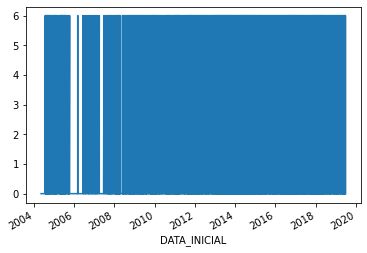

In [404]:
data_per_cmeter_time_idx = data_per_cmeter.copy()
data_per_cmeter_time_idx.index = data_per_cmeter_time_idx['DATA_INICIAL']
data_per_cmeter_time_idx.isna().sum(axis = 1).plot()

Aparenta faltarem valores para 6 colunas na maioria dos casos, e esses casos parecem estar uniformemente distribuídos. Em um caso como esse, imputar valores pode ser contraprodutivo, por gerar muitas instâncias com valores artificiais. Por isso, vamos remover linhas com valores faltantes.

In [405]:
rows_no_nan = ~data_per_cmeter.isna().any(axis = 1)
data_per_cmeter_no_nan = data_per_cmeter[rows_no_nan]
data_per_cmeter_no_nan.isna().sum()

Unnamed:_0                       0
DATA_INICIAL                     0
DATA_FINAL                       0
REGIAO                           0
ESTADO                           0
PRODUTO                          0
NUMERO_DE_POSTOS_PESQUISADOS     0
UNIDADE_DE_MEDIDA                0
PRECO_MEDIO_REVENDA              0
DESVIO_PADRAO_REVENDA            0
PRECO_MINIMO_REVENDA             0
PRECO_MAXIMO_REVENDA             0
MARGEM_MEDIA_REVENDA             0
COEF_DE_VARIACAO_REVENDA         0
PRECO_MEDIO_DISTRIBUICAO         0
DESVIO_PADRAO_DISTRIBUICAO       0
PRECO_MINIMO_DISTRIBUICAO        0
PRECO_MAXIMO_DISTRIBUICAO        0
COEF_DE_VARIACAO_DISTRIBUICAO    0
MES                              0
ANO                              0
dtype: int64

Comecemos com os dados na unidade de R$/l.

In [406]:

data_per_liter_no_nan = data_per_liter[~data_per_liter.isna().any(axis = 1)]
data_per_liter_no_nan.isna().sum()

Unnamed:_0                       0
DATA_INICIAL                     0
DATA_FINAL                       0
REGIAO                           0
ESTADO                           0
PRODUTO                          0
NUMERO_DE_POSTOS_PESQUISADOS     0
UNIDADE_DE_MEDIDA                0
PRECO_MEDIO_REVENDA              0
DESVIO_PADRAO_REVENDA            0
PRECO_MINIMO_REVENDA             0
PRECO_MAXIMO_REVENDA             0
MARGEM_MEDIA_REVENDA             0
COEF_DE_VARIACAO_REVENDA         0
PRECO_MEDIO_DISTRIBUICAO         0
DESVIO_PADRAO_DISTRIBUICAO       0
PRECO_MINIMO_DISTRIBUICAO        0
PRECO_MAXIMO_DISTRIBUICAO        0
COEF_DE_VARIACAO_DISTRIBUICAO    0
MES                              0
ANO                              0
dtype: int64

In [407]:
data_per_liter = data_per_liter_no_nan

Seguiremos com a busca e remoção de outliers indevidos

<AxesSubplot:>

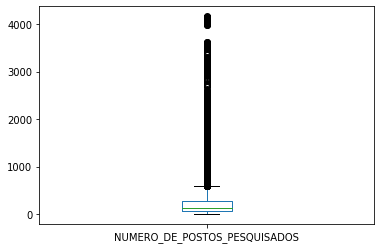

In [408]:
data_per_liter['NUMERO_DE_POSTOS_PESQUISADOS'].plot.box()

O gráfico aponta um grande número de outliers acima do máximo esperado. Apesar de outliers, são valores possíveis, e pode ser melhor mantê-los no dataset. Pode ser interessante julgar se o tempo de pesquisa é proporcional ao número de postos pesquisados

In [409]:
n_stations_per_duration = pd.DataFrame()
n_stations_per_duration['DURACAO'] = (data_per_liter['DATA_FINAL'] - data_per_liter['DATA_INICIAL']).apply(lambda x: x.days)
n_stations_per_duration['N_POSTOS'] = data_per_liter['NUMERO_DE_POSTOS_PESQUISADOS']
n_stations_per_duration.head()

,DURACAO,N_POSTOS
0,6,127
1,6,387
2,6,192
3,6,162
4,6,103


<AxesSubplot:xlabel='DURACAO', ylabel='N_POSTOS'>

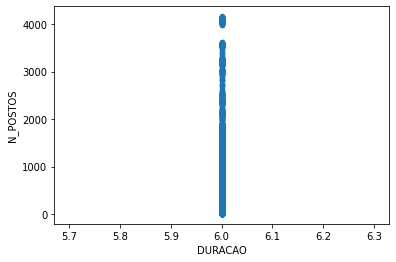

In [410]:
n_stations_per_duration.plot.scatter(x = 'DURACAO', y = 'N_POSTOS')

Descobrimos que todo intervalo entre datas iniciais e finais dura seis dias. Enquanto isso não nos ajuda a determinar se os outliers de quantidades de postos pesquisados devem ser removidos, é importante para nossa compreensão dos dados. Continuemos

<AxesSubplot:>

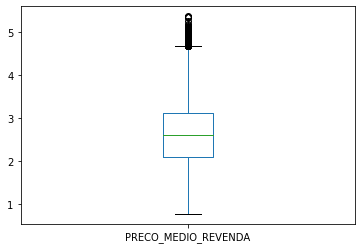

In [411]:
data_per_liter['PRECO_MEDIO_REVENDA'].plot.box()

<AxesSubplot:xlabel='DATA_INICIAL'>

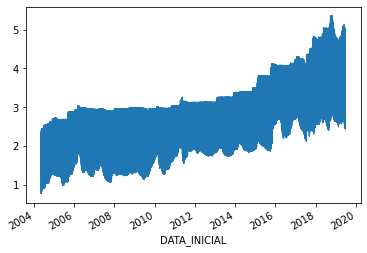

In [412]:
data_per_liter_time_idx = data_per_liter.copy()
data_per_liter_time_idx.index = data_per_liter_time_idx['DATA_INICIAL']
resell_price = data_per_liter_time_idx['PRECO_MEDIO_REVENDA']
resell_price.plot(linewidth=1)

Devido ao fato de a variação do preço médio de revenda ser alta, foi feita uma regressão linear dos preços da gasolina em cada data (o eixo X são datas no formato "ordinal")

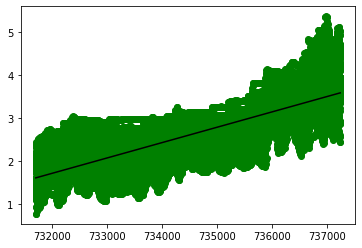

In [413]:
model = LinearRegression()
x = np.array(data_per_liter_time_idx.index).reshape((-1, 1))
aux = []
for i in range(0, len(x)):
    tempo = str(x[i])
    tempo = tempo[2:12]
    som = dt.datetime.strptime(tempo, '%Y-%m-%d').toordinal()
    aux.append(som)
x = np.array(aux).reshape((-1, 1))
y = np.array(resell_price)
model.fit(x, y)
plt.scatter(x, y,color='g')
plt.plot(x, model.predict(x), color = 'k')

Os outliers de preços médios de revenda podem se justificar nos acréscimos recentes ao preços de combustíveis

<AxesSubplot:>

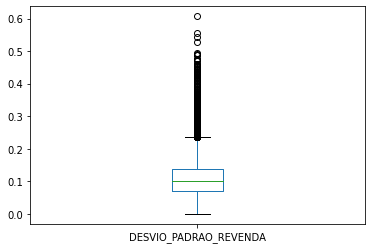

In [414]:
data_per_liter['DESVIO_PADRAO_REVENDA'].plot.box()

Um alto desvio no valor de revenda provoca desconfiança, por sugerir haver postos onde o valor é consideravelmente menor que média, caso bastante inesperado.

<AxesSubplot:>

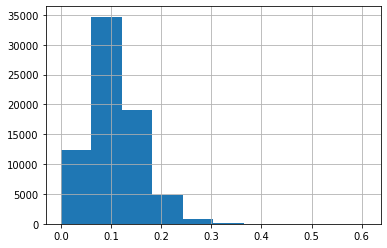

In [415]:
data_per_liter['DESVIO_PADRAO_REVENDA'].hist()

<AxesSubplot:>

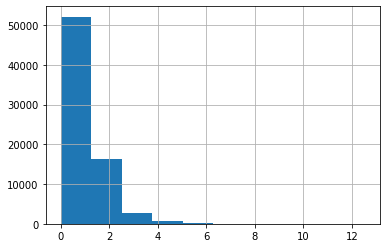

In [416]:
per_liter_resell_std = data_per_liter['DESVIO_PADRAO_REVENDA']
per_liter_resell_std_mad = (np.abs(per_liter_resell_std - per_liter_resell_std.median())/per_liter_resell_std.mad())
per_liter_resell_std_mad.hist()

Removeremos valores acima do limiar de 3.5

In [417]:
data_per_liter_no_resell_out = data_per_liter[per_liter_resell_std_mad < 3.5]

Estudemos agora o boxplot da coluna contendo o preço mínimo de revenda

<AxesSubplot:>

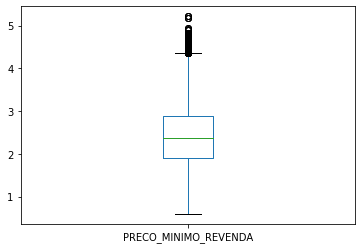

In [418]:
data_per_liter_no_resell_out['PRECO_MINIMO_REVENDA'].plot.box()

Os outliers podem ser condizentes com determinadas épocas, como no caso do preço médio de revenda

<AxesSubplot:xlabel='DATA_INICIAL'>

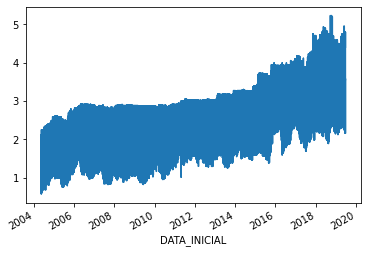

In [419]:
no_resell_out_time_idx = data_per_liter_no_resell_out.copy()
no_resell_out_time_idx.index = no_resell_out_time_idx['DATA_INICIAL']
no_resell_out_time_idx['PRECO_MINIMO_REVENDA'].plot()

Os valores parecem apropriados de acordo com o tempo. Olhemos para os valores máximos de revenda

<AxesSubplot:>

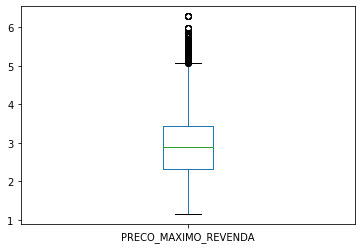

In [420]:
no_resell_out_time_idx['PRECO_MAXIMO_REVENDA'].plot.box()

<AxesSubplot:xlabel='DATA_INICIAL'>

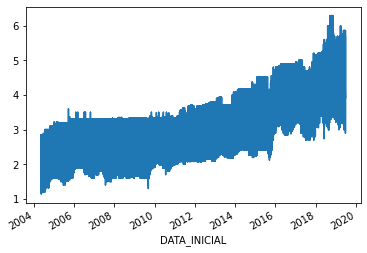

In [421]:
no_resell_out_time_idx['PRECO_MAXIMO_REVENDA'].plot()

Vamos estudar o período enttre 2018 e 2019, onde há outliers no preço de revenda

<AxesSubplot:xlabel='DATA_INICIAL'>

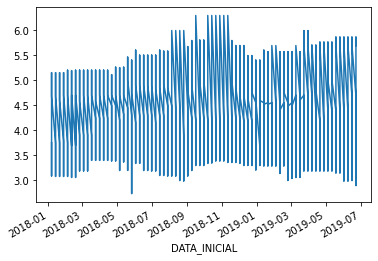

In [422]:
no_resell_out_time_idx['PRECO_MAXIMO_REVENDA']['2018':'2019'].plot()

Podemos considerar inapropriados os valores máximos de revenda caso estejam demasiado distantes do preços médios

<AxesSubplot:xlabel='DATA_INICIAL'>

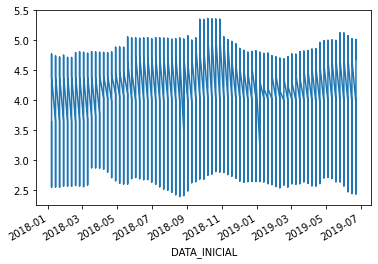

In [423]:
no_resell_out_time_idx['PRECO_MEDIO_REVENDA']['2018':'2019'].plot()

Os valores estão compatíveis, dando a crer que os outliers devem ser mantidos. A próxima coluna a ser observada será a de margem média de revenda

<AxesSubplot:>

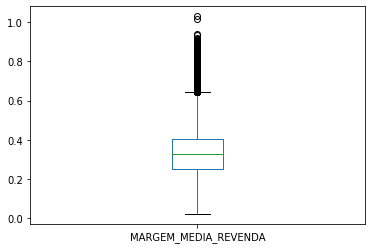

In [424]:
no_resell_out_time_idx['MARGEM_MEDIA_REVENDA'].plot.box()

<AxesSubplot:xlabel='DATA_INICIAL'>

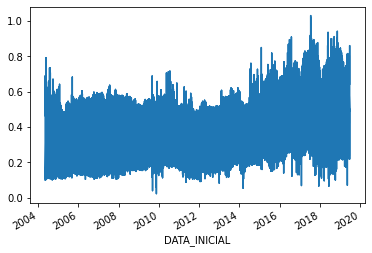

In [425]:
no_resell_out_time_idx['MARGEM_MEDIA_REVENDA'].plot()

Para verificar se os dados são apropriados, podemos utilizar a subtração entre os valores médios de revenda e de distribuição, que devem, em tese, devem se aproximar da margem média de revenda

<AxesSubplot:xlabel='DATA_INICIAL'>

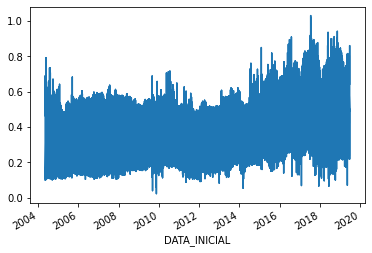

In [426]:
resell_minus_distribution = no_resell_out_time_idx['PRECO_MEDIO_REVENDA'] - no_resell_out_time_idx['PRECO_MEDIO_DISTRIBUICAO']
resell_minus_distribution.plot()

<AxesSubplot:xlabel='DATA_INICIAL'>

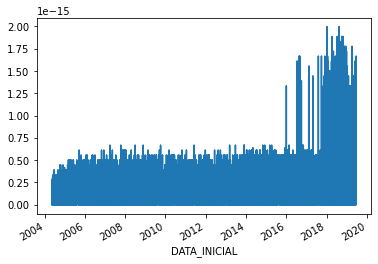

In [427]:
expected_actual_difference = np.abs(resell_minus_distribution - no_resell_out_time_idx['MARGEM_MEDIA_REVENDA'])
expected_actual_difference.plot()

Como temos diferenças ínfimas, e entendemos os valores de preços médios de revenda e distribuição como corretos, tomamos os valores da mergem média de revenda da mesma forma. Verifiquemos agora o coeficiente de variação do preço de revenda

<AxesSubplot:>

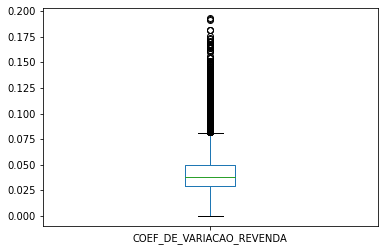

In [428]:
no_resell_out_time_idx['COEF_DE_VARIACAO_REVENDA'].plot.box()

<AxesSubplot:xlabel='DATA_INICIAL'>

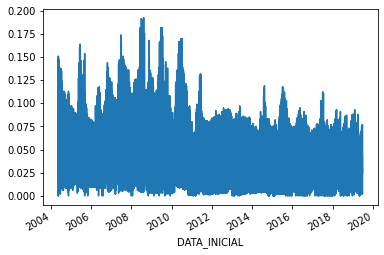

In [429]:
no_resell_out_time_idx['COEF_DE_VARIACAO_REVENDA'].plot()

Apesar de ter picos, não são extremamente repentinos, tendo fases de crescimento vertiginoso os precedendo, bem como de decrescimento rápido os sucedendo. Já verificamos o preço médio de distribuição nos cálculos da margem de revenda, então vamos agora para o desvio padrão de distribuição.

<AxesSubplot:>

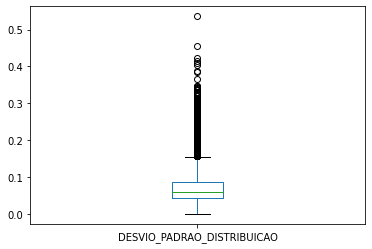

In [430]:
no_resell_out_time_idx['DESVIO_PADRAO_DISTRIBUICAO'].plot.box()

<AxesSubplot:xlabel='DATA_INICIAL'>

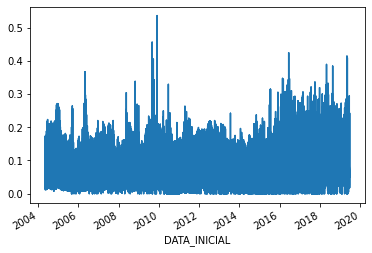

In [431]:
no_resell_out_time_idx['DESVIO_PADRAO_DISTRIBUICAO'].plot()

Parece haver outliers necessitando de remoção. verifiquemos se é possível usar MAD

<AxesSubplot:>

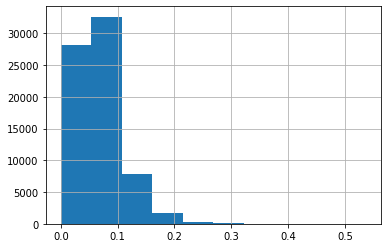

In [432]:
no_resell_out_time_idx['DESVIO_PADRAO_DISTRIBUICAO'].hist()

In [433]:
no_resell_out_time_idx['DESVIO_PADRAO_DISTRIBUICAO'].skew()

1.4958898529265983

Verifiquemos agora com a distribuição log10

<AxesSubplot:>

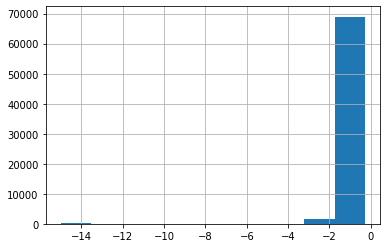

In [434]:
dist_std = no_resell_out_time_idx['DESVIO_PADRAO_DISTRIBUICAO']
dist_std_no_zero = dist_std.replace({ 0: 1e-15 })
np.log10(dist_std_no_zero).hist()

Infelizmente, a distribuição utilizando log10 continua assimétrica. O próximo método será obter a raiz quadrada

<AxesSubplot:>

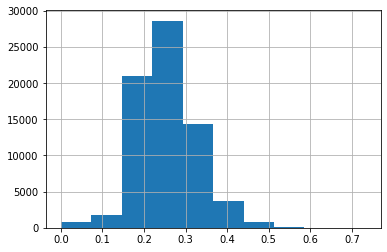

In [435]:
np.sqrt(dist_std_no_zero).hist()

In [436]:
no_resell_out_dist_std_mad = np.sqrt(no_resell_out_time_idx['DESVIO_PADRAO_DISTRIBUICAO'])
no_resell_out_dist_std_mad = np.abs(no_resell_out_dist_std_mad - no_resell_out_dist_std_mad.median()) / no_resell_out_dist_std_mad.mad()
(no_resell_out_dist_std_mad < 3.5).sum()

69582

In [437]:
no_dist_std_out_time_idx = no_resell_out_time_idx[no_resell_out_dist_std_mad < 3.5]
len(no_dist_std_out_time_idx)

69582

Analisaremos em seguida a distribuição de valores para preço mínimo de distribuição

<AxesSubplot:>

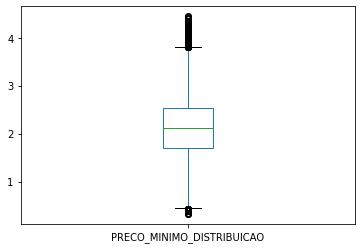

In [438]:
no_dist_std_out_time_idx['PRECO_MINIMO_DISTRIBUICAO'].plot.box()

<AxesSubplot:xlabel='DATA_INICIAL'>

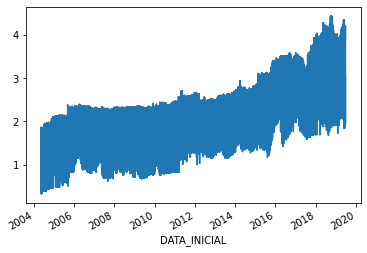

In [439]:
no_dist_std_out_time_idx['PRECO_MINIMO_DISTRIBUICAO'].plot()

Os valores condizem com as épocas. Vejamos o preço máximo de distribuição

<AxesSubplot:>

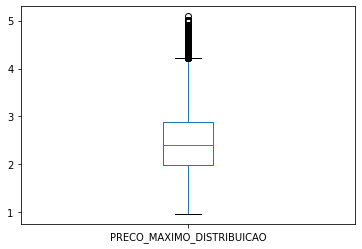

In [440]:
no_dist_std_out_time_idx['PRECO_MAXIMO_DISTRIBUICAO'].plot.box()

<AxesSubplot:xlabel='DATA_INICIAL'>

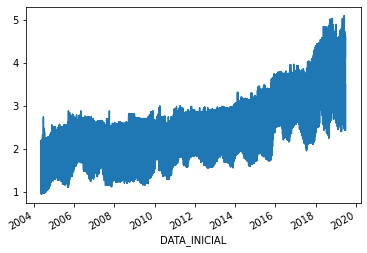

In [441]:
no_dist_std_out_time_idx['PRECO_MAXIMO_DISTRIBUICAO'].plot()

Assim como para o preço mínimo de distribuição, esses valores condizem com suas épocas. De valor numérico a analisar resta agora somente o coeficiente de variação do valor de distribuição

<AxesSubplot:>

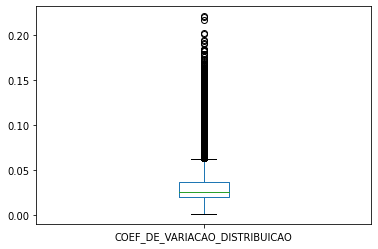

In [442]:
no_dist_std_out_time_idx['COEF_DE_VARIACAO_DISTRIBUICAO'].plot.box()

O boxplot sugere uma distribuição enviesada. Verifiquemos como esse valor varia com o tempo

<AxesSubplot:xlabel='DATA_INICIAL'>

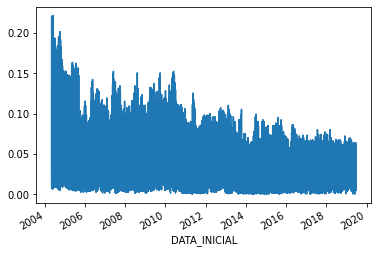

In [443]:
no_dist_std_out_time_idx['COEF_DE_VARIACAO_DISTRIBUICAO'].plot()

É interessante removermos outliers, que parecem se concentrar no início do período retratado. Verifiquemos se é possível obter uma distribuição simétrica utilizando o logaritmo ou raiz quadrada

<AxesSubplot:>

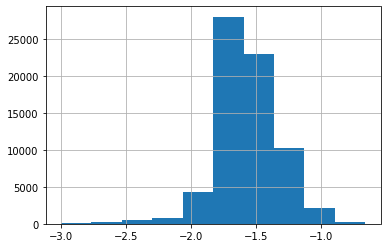

In [444]:
coef_dist_log = no_dist_std_out_time_idx['COEF_DE_VARIACAO_DISTRIBUICAO']
coef_dist_log = coef_dist_log.replace({ 0: 1e-15 })
np.log10(coef_dist_log).hist()

<AxesSubplot:>

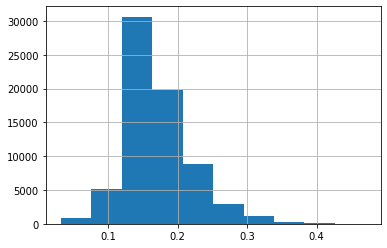

In [445]:
np.sqrt(coef_dist_log).hist()

Não conseguimos obter uma distribuição simétrica usando o logaritmo nem a raiz e, portanto, manteremos os dados. Prossigamos

In [446]:
per_liter_clean = no_dist_std_out_time_idx
grouped_by_state = per_liter_clean.groupby('ESTADO')

<AxesSubplot:xlabel='ESTADO'>

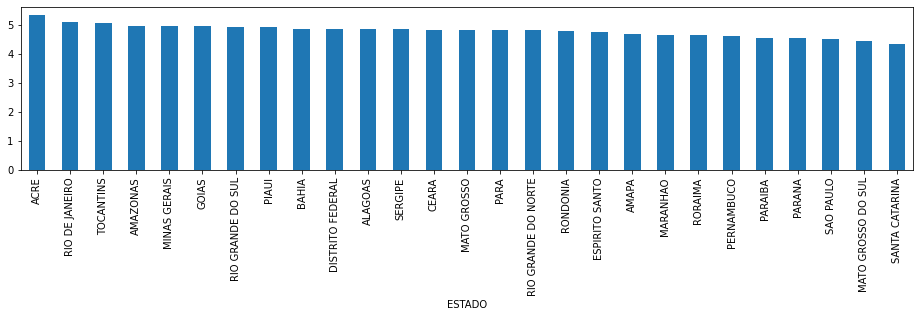

In [447]:
grouped_by_state['PRECO_MEDIO_REVENDA'].max().sort_values(ascending=False).plot.bar(figsize=(16, 3), rot=90)

As diferenças entre os máximos dos preços médios de revenda por estado não aparentam ser muito grandes visualmente. Vejamos o valor da maior diferença.

In [448]:
mean_resell_by_state = grouped_by_state['PRECO_MEDIO_REVENDA']
mean_resell_by_state.max().max() - mean_resell_by_state.max().min()

0.9959999999999996

Plotemos os gráficos da evolução do preço médio para os dois estados com maior diferença, Acre e Santa Catarina.

<AxesSubplot:xlabel='DATA_INICIAL'>

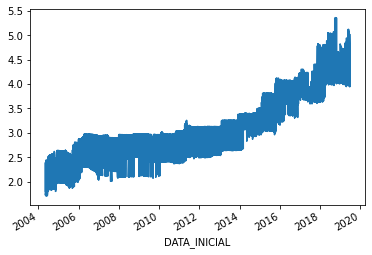

In [449]:
per_liter_clean[per_liter_clean['ESTADO'] == 'ACRE']['PRECO_MEDIO_REVENDA'].plot()

<AxesSubplot:xlabel='DATA_INICIAL'>

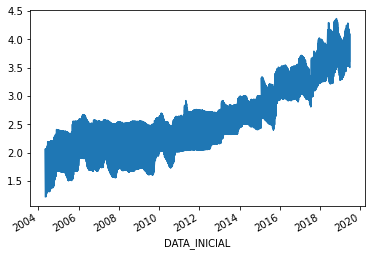

In [450]:
per_liter_clean[per_liter_clean['ESTADO'] == 'SANTA CATARINA']['PRECO_MEDIO_REVENDA'].plot()

In [451]:
mean_resell_acre = per_liter_clean[per_liter_clean['ESTADO'] == 'ACRE']
mean_resell_santa_catarina = per_liter_clean[per_liter_clean['ESTADO'] == 'SANTA CATARINA']

<AxesSubplot:xlabel='DATA_INICIAL'>

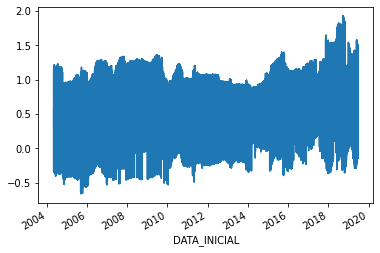

In [452]:
(mean_resell_acre['PRECO_MEDIO_REVENDA'] - mean_resell_santa_catarina['PRECO_MEDIO_REVENDA']).plot()

As curvas de evolução do preço médio de revenda tem formatos semelhantes, sendo que Santa Catarina historicamente tem preços médios mais baixos que o Acre. Pelo gráfico das diferenças com relação ao tempo, vê-se que, em certo ponto próximo a 2019, essa diferença esteve próxima de dois reais. Vamos procurar nos informar da data em que houve a maior diferença entre um máximo e um mínimo preço médio de revenda.

In [453]:
grouped_by_date = per_liter_clean.reset_index(drop=True).groupby('DATA_INICIAL')

In [454]:
max_diffs = (grouped_by_date['PRECO_MEDIO_REVENDA'].max() - grouped_by_date['PRECO_MEDIO_REVENDA'].min())
max_diffs[max_diffs == max_diffs.max()]

DATA_INICIAL
2018-09-30    2.663
Name: PRECO_MEDIO_REVENDA, dtype: float64

O resultado aponta para a pesquisa da data de 30 de setembro de 2018. É um detalhe importante que um estado pode aparecer mais de uma vez para uma pesquisa, portanto o que mostra o gráfico pode não refletir o resultado obtido acima. Vamos obter os valores médios de preços médios de revenda para essa data, e plotá-los em seguida.

<AxesSubplot:xlabel='ESTADO'>

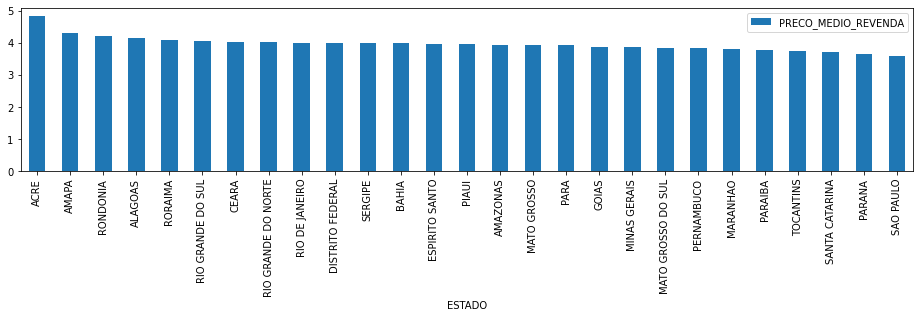

In [455]:
per_liter_clean.loc['2018-09-30'].groupby('ESTADO').mean().sort_values('PRECO_MEDIO_REVENDA', ascending=False).plot.bar(y='PRECO_MEDIO_REVENDA', figsize=(16, 3))

Vamos utilizar a normalização min-max para os dados

In [456]:
data_per_liter_norm = no_dist_std_out_time_idx.copy()
cols_to_norm = data_per_liter_norm[
    [
     'NUMERO_DE_POSTOS_PESQUISADOS',
     'PRECO_MEDIO_REVENDA',
     'PRECO_MEDIO_DISTRIBUICAO',
     'DESVIO_PADRAO_REVENDA',
     'PRECO_MINIMO_REVENDA',
     'PRECO_MAXIMO_REVENDA',
     'PRECO_MINIMO_DISTRIBUICAO',
     'PRECO_MAXIMO_DISTRIBUICAO',
     'COEF_DE_VARIACAO_REVENDA',
     'MARGEM_MEDIA_REVENDA'
    ]
]

data_per_liter_norm[
    [
     'NUMERO_DE_POSTOS_PESQUISADOS',
     'PRECO_MEDIO_REVENDA',
     'PRECO_MEDIO_DISTRIBUICAO',
     'DESVIO_PADRAO_REVENDA',
     'PRECO_MINIMO_REVENDA',
     'PRECO_MAXIMO_REVENDA',
     'PRECO_MINIMO_DISTRIBUICAO',
     'PRECO_MAXIMO_DISTRIBUICAO',
     'COEF_DE_VARIACAO_REVENDA',
     'MARGEM_MEDIA_REVENDA'
    ]
] = (cols_to_norm - cols_to_norm.min()) / (cols_to_norm.max() - cols_to_norm.min())

data_per_liter_norm.describe()

,Unnamed:_0,NUMERO_DE_POSTOS_PESQUISADOS,PRECO_MEDIO_REVENDA,DESVIO_PADRAO_REVENDA,PRECO_MINIMO_REVENDA,PRECO_MAXIMO_REVENDA,MARGEM_MEDIA_REVENDA,COEF_DE_VARIACAO_REVENDA,PRECO_MEDIO_DISTRIBUICAO,DESVIO_PADRAO_DISTRIBUICAO,PRECO_MINIMO_DISTRIBUICAO,PRECO_MAXIMO_DISTRIBUICAO,COEF_DE_VARIACAO_DISTRIBUICAO,MES,ANO
count,69582.000000,69582.000000,69582.000000,69582.000000,69582.000000,69582.000000,69582.000000,69582.000000,69582.000000,69582.000000,69582.000000,69582.000000,69582.000000,69582.000000,69582.000000
mean,52168.015119,0.064415,0.408085,0.433573,0.397086,0.349395,0.303204,0.211229,0.424679,0.068039,0.443886,0.367928,0.031194,6.480555,2011.841195
std,32673.486341,0.106765,0.152596,0.190763,0.146849,0.147735,0.114956,0.094927,0.154132,0.034367,0.155064,0.154929,0.019007,3.446606,4.371979
min,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.003000,0.000000,0.000000,0.001000,1.000000,2004.000000
25%,17924.250000,0.013926,0.285030,0.290456,0.282937,0.227626,0.214359,0.150259,0.309046,0.043000,0.334911,0.246890,0.020000,4.000000,2008.000000
50%,54858.500000,0.028331,0.394691,0.410788,0.382289,0.335603,0.294359,0.196891,0.407824,0.061000,0.434593,0.347627,0.026000,6.000000,2012.000000
75%,79888.750000,0.067467,0.504787,0.556017,0.492441,0.437743,0.376410,0.259067,0.520538,0.087000,0.538685,0.463955,0.037000,9.000000,2016.000000
max,106780.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,0.193000,1.000000,1.000000,0.221000,12.000000,2019.000000


Agora com os dados na unidade de R$/13kg.

In [457]:
data_per_13kg_no_nan = data_per_13kg[~data_per_13kg.isna().any(axis = 1)]
data_per_13kg_no_nan.isna().sum()

Unnamed:_0                       0
DATA_INICIAL                     0
DATA_FINAL                       0
REGIAO                           0
ESTADO                           0
PRODUTO                          0
NUMERO_DE_POSTOS_PESQUISADOS     0
UNIDADE_DE_MEDIDA                0
PRECO_MEDIO_REVENDA              0
DESVIO_PADRAO_REVENDA            0
PRECO_MINIMO_REVENDA             0
PRECO_MAXIMO_REVENDA             0
MARGEM_MEDIA_REVENDA             0
COEF_DE_VARIACAO_REVENDA         0
PRECO_MEDIO_DISTRIBUICAO         0
DESVIO_PADRAO_DISTRIBUICAO       0
PRECO_MINIMO_DISTRIBUICAO        0
PRECO_MAXIMO_DISTRIBUICAO        0
COEF_DE_VARIACAO_DISTRIBUICAO    0
MES                              0
ANO                              0
dtype: int64

Seguiremos com a busca e remoção de outliers indevidos

<AxesSubplot:>

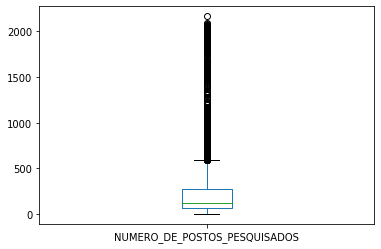

In [458]:
data_per_13kg['NUMERO_DE_POSTOS_PESQUISADOS'].plot.box()

O gráfico aponta um grande número de outliers acima do máximo esperado. Apesar de outliers, são valores possíveis, e pode ser melhor mantê-los no dataset. Pode ser interessante julgar se o tempo de pesquisa é proporcional ao número de postos pesquisados

In [459]:
n_stations_per_duration = pd.DataFrame()
n_stations_per_duration['DURACAO'] = (data_per_13kg['DATA_FINAL'] - data_per_13kg['DATA_INICIAL']).apply(lambda x: x.days)
n_stations_per_duration['N_POSTOS'] = data_per_13kg['NUMERO_DE_POSTOS_PESQUISADOS']
n_stations_per_duration.head()

,DURACAO,N_POSTOS
24132,6,44
24133,6,372
24134,6,97
24135,6,109
24136,6,22


<AxesSubplot:xlabel='DURACAO', ylabel='N_POSTOS'>

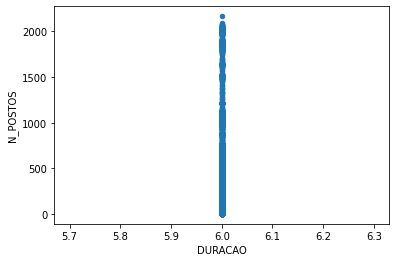

In [460]:
n_stations_per_duration.plot.scatter(x = 'DURACAO', y = 'N_POSTOS')

Descobrimos que todo intervalo entre datas iniciais e finais dura seis dias. Enquanto isso não nos ajuda a determinar se os outliers de quantidades de postos pesquisados devem ser removidos, é importante para nossa compreensão dos dados. Continuemos

<AxesSubplot:>

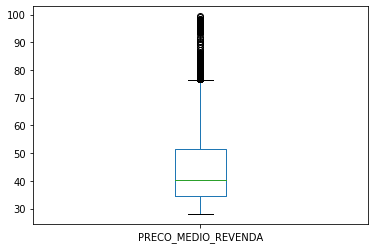

In [461]:
data_per_13kg['PRECO_MEDIO_REVENDA'].plot.box()

<AxesSubplot:xlabel='DATA_INICIAL'>

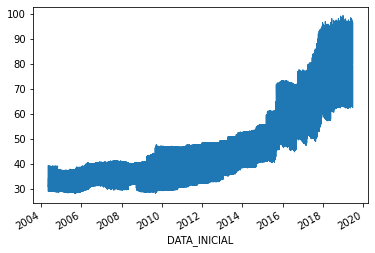

In [462]:
data_per_13kg_time_idx = data_per_13kg.copy()
data_per_13kg_time_idx.index = data_per_13kg_time_idx['DATA_INICIAL']
resell_price = data_per_13kg_time_idx['PRECO_MEDIO_REVENDA']
resell_price.plot(linewidth=1)

Devido ao fato de a variação do preço médio de revenda ser alta, foi feita uma regressão linear dos preços da gasolina em cada data (o eixo X são datas no formato "ordinal")

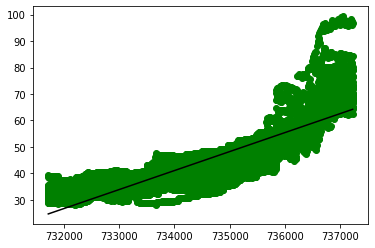

In [463]:
model = LinearRegression()
x = np.array(data_per_13kg_time_idx.index).reshape((-1, 1))
aux = []
for i in range(0, len(x)):
    tempo = str(x[i])
    tempo = tempo[2:12]
    som = dt.datetime.strptime(tempo, '%Y-%m-%d').toordinal()
    aux.append(som)
x = np.array(aux).reshape((-1, 1))
y = np.array(resell_price)
model.fit(x, y)
plt.scatter(x, y,color='g')
plt.plot(x, model.predict(x), color = 'k')

Os outliers de preços médios de revenda podem se justificar nos acréscimos recentes ao preços de combustíveis

<AxesSubplot:>

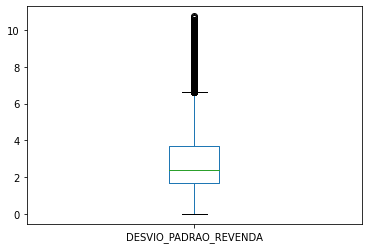

In [464]:
data_per_13kg['DESVIO_PADRAO_REVENDA'].plot.box()

Um alto desvio no valor de revenda provoca desconfiança, por sugerir haver postos onde o valor é consideravelmente menor que média, caso bastante inesperado.

<AxesSubplot:>

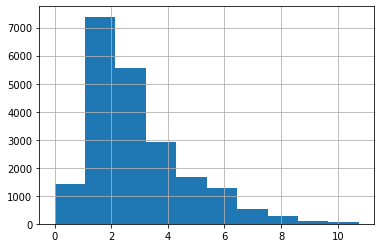

In [465]:
data_per_13kg['DESVIO_PADRAO_REVENDA'].hist()

<AxesSubplot:>

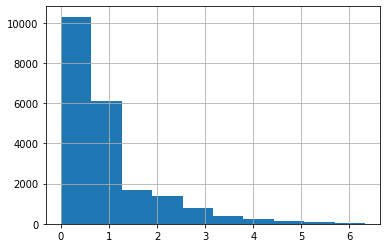

In [466]:
per_13kg_resell_std = data_per_13kg['DESVIO_PADRAO_REVENDA']
per_13kg_resell_std_mad = (np.abs(per_13kg_resell_std - per_13kg_resell_std.median())/per_13kg_resell_std.mad())
per_13kg_resell_std_mad.hist()

Removeremos valores acima do limiar de 4.5

In [467]:
data_per_13kg_no_resell_out = data_per_13kg[per_13kg_resell_std_mad < 4.5]

Estudemos agora o boxplot da coluna contendo o preço mínimo de revenda

<AxesSubplot:>

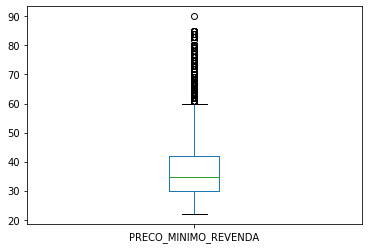

In [468]:
data_per_13kg_no_resell_out['PRECO_MINIMO_REVENDA'].plot.box()

Os outliers podem ser condizentes com determinadas épocas, como no caso do preço médio de revenda

<AxesSubplot:xlabel='DATA_INICIAL'>

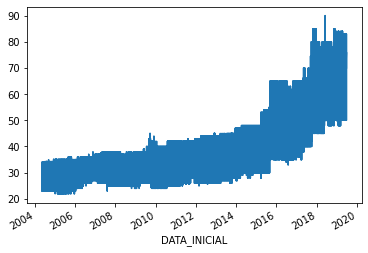

In [469]:
no_resell_out_time_idx = data_per_13kg_no_resell_out.copy()
no_resell_out_time_idx.index = no_resell_out_time_idx['DATA_INICIAL']
no_resell_out_time_idx['PRECO_MINIMO_REVENDA'].plot()

Os valores parecem apropriados de acordo com o tempo. Olhemos para os valores máximos de revenda

<AxesSubplot:>

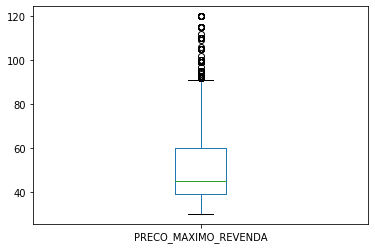

In [470]:
no_resell_out_time_idx['PRECO_MAXIMO_REVENDA'].plot.box()

<AxesSubplot:xlabel='DATA_INICIAL'>

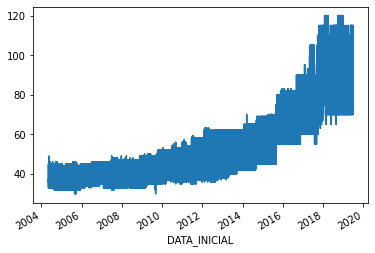

In [471]:
no_resell_out_time_idx['PRECO_MAXIMO_REVENDA'].plot()

Vamos estudar o período enttre 2018 e 2019, onde há outliers no preço de revenda

<AxesSubplot:xlabel='DATA_INICIAL'>

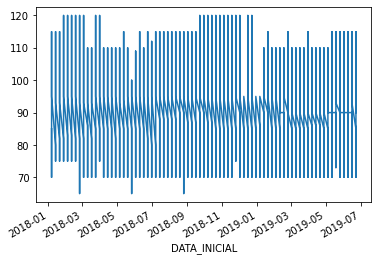

In [472]:
no_resell_out_time_idx['PRECO_MAXIMO_REVENDA']['2018':'2019'].plot()

Podemos considerar inapropriados os valores máximos de revenda caso estejam demasiado distantes do preços médios

<AxesSubplot:xlabel='DATA_INICIAL'>

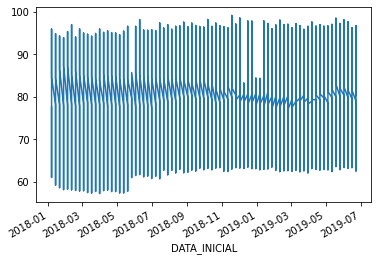

In [473]:
no_resell_out_time_idx['PRECO_MEDIO_REVENDA']['2018':'2019'].plot()

Os valores estão compatíveis, dando a crer que os outliers devem ser mantidos. A próxima coluna a ser observada será a de margem média de revenda

<AxesSubplot:>

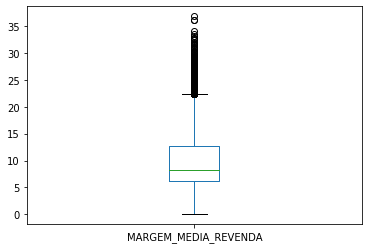

In [474]:
no_resell_out_time_idx['MARGEM_MEDIA_REVENDA'].plot.box()

<AxesSubplot:xlabel='DATA_INICIAL'>

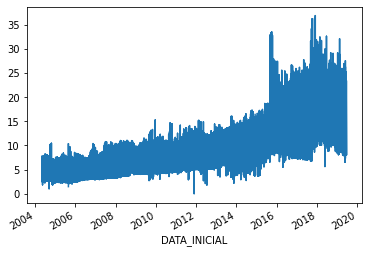

In [475]:
no_resell_out_time_idx['MARGEM_MEDIA_REVENDA'].plot()

Para verificar se os dados são apropriados, podemos utilizar a subtração entre os valores médios de revenda e de distribuição, que devem, em tese, devem se aproximar da margem média de revenda

<AxesSubplot:xlabel='DATA_INICIAL'>

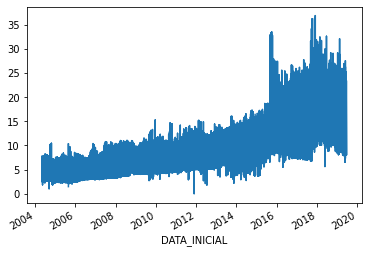

In [476]:
resell_minus_distribution = no_resell_out_time_idx['PRECO_MEDIO_REVENDA'] - no_resell_out_time_idx['PRECO_MEDIO_DISTRIBUICAO']
resell_minus_distribution.plot()

<AxesSubplot:xlabel='DATA_INICIAL'>

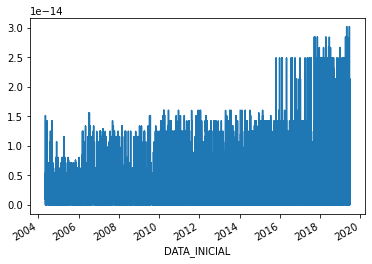

In [477]:
expected_actual_difference = np.abs(resell_minus_distribution - no_resell_out_time_idx['MARGEM_MEDIA_REVENDA'])
expected_actual_difference.plot()

Como temos diferenças ínfimas, e entendemos os valores de preços médios de revenda e distribuição como corretos, tomamos os valores da mergem média de revenda da mesma forma. Verifiquemos agora o coeficiente de variação do preço de revenda

<AxesSubplot:>

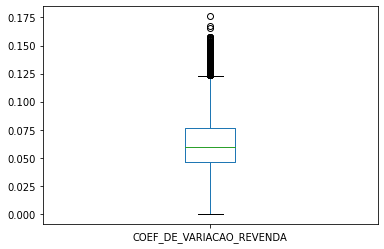

In [478]:
no_resell_out_time_idx['COEF_DE_VARIACAO_REVENDA'].plot.box()

<AxesSubplot:xlabel='DATA_INICIAL'>

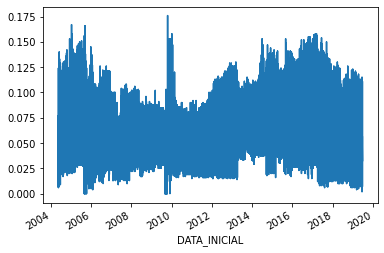

In [479]:
no_resell_out_time_idx['COEF_DE_VARIACAO_REVENDA'].plot()

Apesar de ter picos, não são extremamente repentinos, tendo fases de crescimento vertiginoso os precedendo, bem como de decrescimento rápido os sucedendo. Já verificamos o preço médio de distribuição nos cálculos da margem de revenda, então vamos agora para o desvio padrão de distribuição.

<AxesSubplot:>

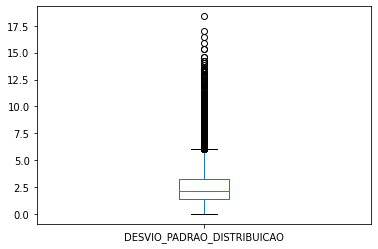

In [480]:
no_resell_out_time_idx['DESVIO_PADRAO_DISTRIBUICAO'].plot.box()

<AxesSubplot:xlabel='DATA_INICIAL'>

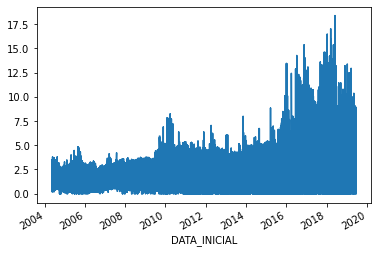

In [481]:
no_resell_out_time_idx['DESVIO_PADRAO_DISTRIBUICAO'].plot()

Parece haver outliers necessitando de remoção. verifiquemos se é possível usar MAD

<AxesSubplot:>

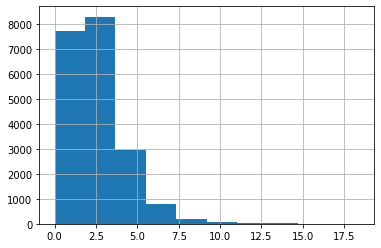

In [482]:
no_resell_out_time_idx['DESVIO_PADRAO_DISTRIBUICAO'].hist()

In [483]:
no_resell_out_time_idx['DESVIO_PADRAO_DISTRIBUICAO'].skew()

1.5840993784457562

Verifiquemos agora com a distribuição log10

<AxesSubplot:>

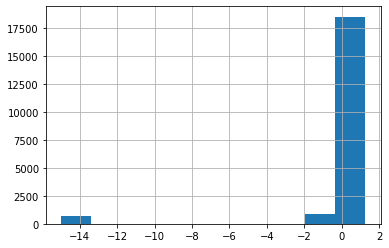

In [484]:
dist_std = no_resell_out_time_idx['DESVIO_PADRAO_DISTRIBUICAO']
dist_std_no_zero = dist_std.replace({ 0: 1e-15 })
np.log10(dist_std_no_zero).hist()

Infelizmente, a distribuição utilizando log10 continua assimétrica. O próximo método será obter a raiz quadrada

<AxesSubplot:>

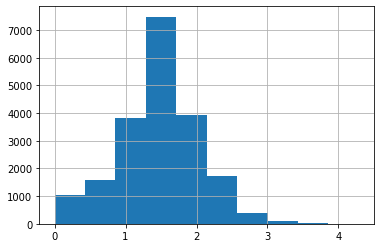

In [485]:
np.sqrt(dist_std_no_zero).hist()

In [486]:
no_resell_out_dist_std_mad = np.sqrt(no_resell_out_time_idx['DESVIO_PADRAO_DISTRIBUICAO'])
no_resell_out_dist_std_mad = np.abs(no_resell_out_dist_std_mad - no_resell_out_dist_std_mad.median()) / no_resell_out_dist_std_mad.mad()
(no_resell_out_dist_std_mad < 4.5).sum()

20061

In [487]:
no_dist_std_out_time_idx = no_resell_out_time_idx[no_resell_out_dist_std_mad < 3.5]
len(no_dist_std_out_time_idx)

19967

Analisaremos em seguida a distribuição de valores para preço mínimo de distribuição

<AxesSubplot:>

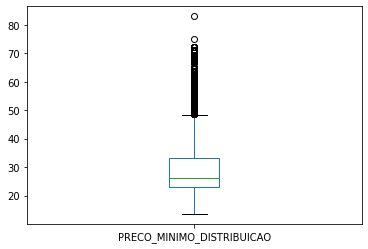

In [488]:
no_dist_std_out_time_idx['PRECO_MINIMO_DISTRIBUICAO'].plot.box()

<AxesSubplot:xlabel='DATA_INICIAL'>

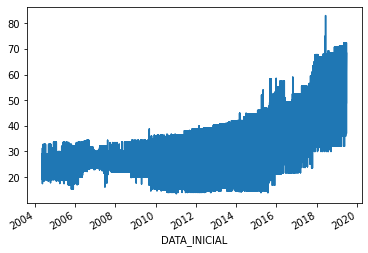

In [489]:
no_dist_std_out_time_idx['PRECO_MINIMO_DISTRIBUICAO'].plot()

Os valores condizem com as épocas. Vejamos o preço máximo de distribuição

<AxesSubplot:>

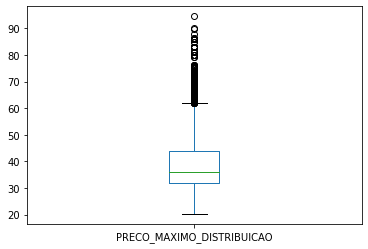

In [490]:
no_dist_std_out_time_idx['PRECO_MAXIMO_DISTRIBUICAO'].plot.box()

<AxesSubplot:xlabel='DATA_INICIAL'>

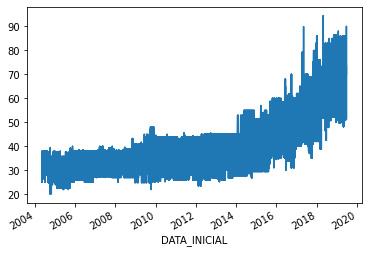

In [491]:
no_dist_std_out_time_idx['PRECO_MAXIMO_DISTRIBUICAO'].plot()

Assim como para o preço mínimo de distribuição, esses valores condizem com suas épocas. De valor numérico a analisar resta agora somente o coeficiente de variação do valor de distribuição

<AxesSubplot:>

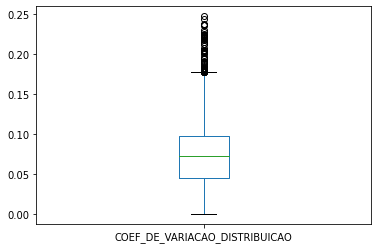

In [492]:
no_dist_std_out_time_idx['COEF_DE_VARIACAO_DISTRIBUICAO'].plot.box()

O boxplot sugere uma distribuição enviesada. Verifiquemos como esse valor varia com o tempo

<AxesSubplot:xlabel='DATA_INICIAL'>

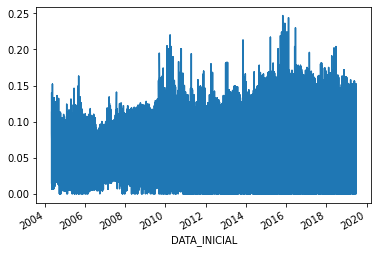

In [493]:
no_dist_std_out_time_idx['COEF_DE_VARIACAO_DISTRIBUICAO'].plot()

É interessante removermos outliers, que parecem se concentrar no início do período retratado. Verifiquemos se é possível obter uma distribuição simétrica utilizando o logaritmo ou raiz quadrada

<AxesSubplot:>

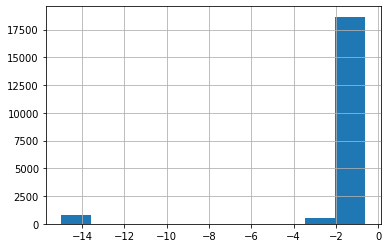

In [494]:
coef_dist_log = no_dist_std_out_time_idx['COEF_DE_VARIACAO_DISTRIBUICAO']
coef_dist_log = coef_dist_log.replace({ 0: 1e-15 })
np.log10(coef_dist_log).hist()

<AxesSubplot:>

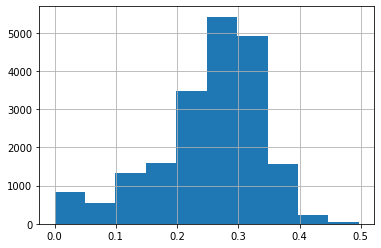

In [495]:
np.sqrt(coef_dist_log).hist()

Não conseguimos obter uma distribuição simétrica usando o logaritmo nem a raiz e, portanto, manteremos os dados. Prossigamos

<AxesSubplot:xlabel='ESTADO'>

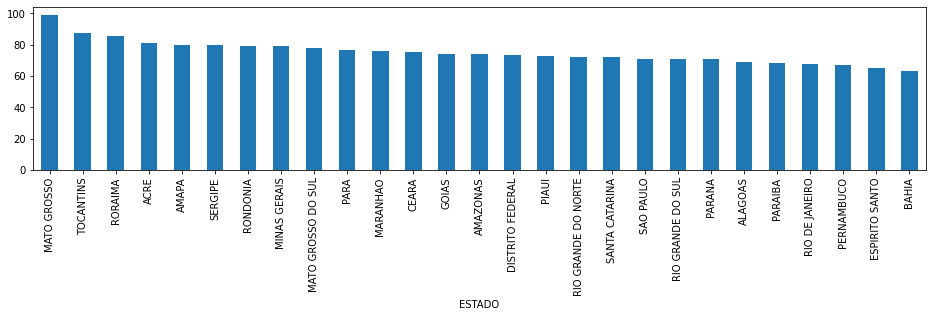

In [496]:
per_13kg_clean = no_dist_std_out_time_idx
grouped_by_state = per_13kg_clean.groupby('ESTADO')
grouped_by_state['PRECO_MEDIO_REVENDA'].max().sort_values(ascending=False).plot.bar(figsize=(16, 3), rot=90)

A diferença entre os preços médios para R$/13kg por estado é considerável. Vejamos a diferença de maior valor

In [497]:
mean_resell_by_state = grouped_by_state['PRECO_MEDIO_REVENDA']
mean_resell_by_state.max().max() - mean_resell_by_state.max().min()

35.522999999999996

Plotemos os gráficos da evolução do preço médio para os dois estados com maior diferença, Mato Grosso e Bahia.

<AxesSubplot:xlabel='DATA_INICIAL'>

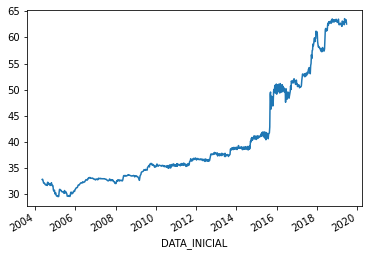

In [498]:
per_13kg_clean[per_13kg_clean['ESTADO'] == 'BAHIA']['PRECO_MEDIO_REVENDA'].plot()

<AxesSubplot:xlabel='DATA_INICIAL'>

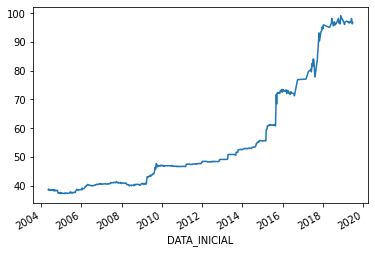

In [499]:
per_13kg_clean[per_13kg_clean['ESTADO'] == 'MATO GROSSO']['PRECO_MEDIO_REVENDA'].plot()

<AxesSubplot:xlabel='DATA_INICIAL'>

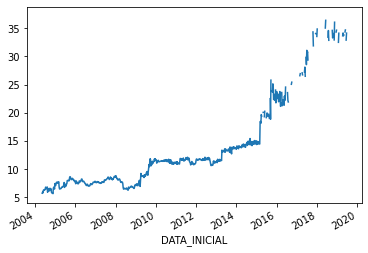

In [500]:
mean_resell_BA = per_13kg_clean[per_13kg_clean['ESTADO'] == 'BAHIA']
mean_resell_MT = per_13kg_clean[per_13kg_clean['ESTADO'] == 'MATO GROSSO']

(mean_resell_MT['PRECO_MEDIO_REVENDA'] - mean_resell_BA['PRECO_MEDIO_REVENDA']).plot()

As curvas de evolução do preço médio de revenda tem formatos semelhantes,
sendo que Bahia historicamente tem preços médios mais baixos que o Mato Grosso.
Pelo gráfico das diferenças com relação ao tempo, vê-se que, em certo ponto entre 2018 e 2020,
essa diferença esteve acima de R$35,00. Vamos procurar nos informar da data em que houve
a maior diferença entre um máximo e um mínimo preço médio de revenda.

In [501]:
grouped_by_date = per_13kg_clean.reset_index(drop=True).groupby('DATA_INICIAL')

max_diffs = (grouped_by_date['PRECO_MEDIO_REVENDA'].max() - grouped_by_date['PRECO_MEDIO_REVENDA'].min())
max_diffs[max_diffs == max_diffs.max()]

DATA_INICIAL
2017-11-26    37.733
Name: PRECO_MEDIO_REVENDA, dtype: float64

O resultado aponta para a pesquisa da data de 26 de novembro de 2017.
 É um detalhe importante que um estado pode aparecer mais de uma vez para uma pesquisa,
 portanto o que mostra o gráfico pode não refletir o resultado obtido acima. Vamos obter
os valores médios de preços médios de revenda para essa data, e plotá-los em seguida.

<AxesSubplot:xlabel='ESTADO'>

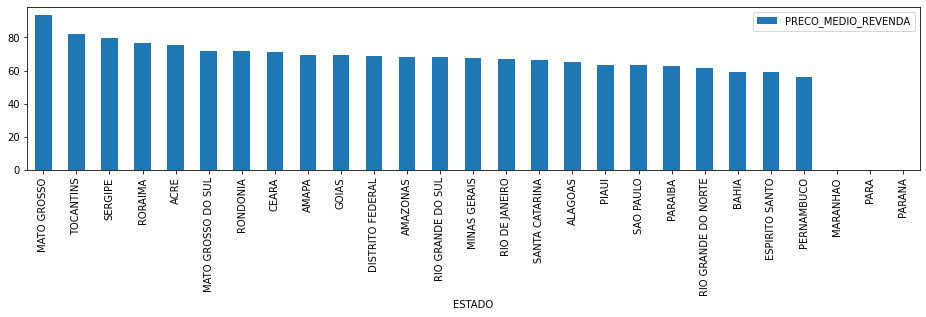

In [502]:
per_13kg_clean.loc['2017-11-26'].groupby('ESTADO').mean().sort_values('PRECO_MEDIO_REVENDA', ascending=False).plot.bar(y='PRECO_MEDIO_REVENDA', figsize=(16, 3))

Vamos utilizar a normalização min-max para os dados

In [503]:
data_per_13kg_norm = no_dist_std_out_time_idx.copy()
cols_to_norm = data_per_13kg_norm[
    [
     'NUMERO_DE_POSTOS_PESQUISADOS',
     'PRECO_MEDIO_REVENDA',
     'PRECO_MEDIO_DISTRIBUICAO',
     'DESVIO_PADRAO_REVENDA',
     'PRECO_MINIMO_REVENDA',
     'PRECO_MAXIMO_REVENDA',
     'PRECO_MINIMO_DISTRIBUICAO',
     'PRECO_MAXIMO_DISTRIBUICAO',
     'COEF_DE_VARIACAO_REVENDA',
     'MARGEM_MEDIA_REVENDA'
    ]
]

data_per_13kg_norm[
    [
     'NUMERO_DE_POSTOS_PESQUISADOS',
     'PRECO_MEDIO_REVENDA',
     'PRECO_MEDIO_DISTRIBUICAO',
     'DESVIO_PADRAO_REVENDA',
     'PRECO_MINIMO_REVENDA',
     'PRECO_MAXIMO_REVENDA',
     'PRECO_MINIMO_DISTRIBUICAO',
     'PRECO_MAXIMO_DISTRIBUICAO',
     'COEF_DE_VARIACAO_REVENDA',
     'MARGEM_MEDIA_REVENDA'
    ]
] = (cols_to_norm - cols_to_norm.min()) / (cols_to_norm.max() - cols_to_norm.min())

data_per_13kg_norm.describe()

,Unnamed:_0,NUMERO_DE_POSTOS_PESQUISADOS,PRECO_MEDIO_REVENDA,DESVIO_PADRAO_REVENDA,PRECO_MINIMO_REVENDA,PRECO_MAXIMO_REVENDA,MARGEM_MEDIA_REVENDA,COEF_DE_VARIACAO_REVENDA,PRECO_MEDIO_DISTRIBUICAO,DESVIO_PADRAO_DISTRIBUICAO,PRECO_MINIMO_DISTRIBUICAO,PRECO_MAXIMO_DISTRIBUICAO,COEF_DE_VARIACAO_DISTRIBUICAO,MES,ANO
count,19967.000000,19967.000000,19967.000000,19967.000000,19967.000000,19967.000000,19967.000000,19967.000000,19967.000000,19967.000000,19967.000000,19967.000000,19967.000000,19967.000000,19967.000000
mean,50984.244554,0.124313,0.223921,0.337495,0.228112,0.233696,0.289372,0.372522,0.222042,2.443851,0.224649,0.262059,0.071747,6.504633,2011.234587
std,27124.561531,0.172218,0.180889,0.189386,0.164473,0.176130,0.145212,0.146674,0.150148,1.591407,0.135290,0.149931,0.038795,3.440667,4.392238
min,24132.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000,2004.000000
25%,29142.500000,0.030975,0.089301,0.201117,0.117777,0.100000,0.181690,0.269461,0.113810,1.422000,0.136193,0.158136,0.045000,4.000000,2007.000000
50%,34212.000000,0.058252,0.160762,0.280207,0.176592,0.166667,0.242772,0.359281,0.168313,2.163000,0.180248,0.212015,0.073000,6.000000,2011.000000
75%,75849.500000,0.131761,0.319871,0.432260,0.294221,0.333333,0.372634,0.455090,0.285025,3.244000,0.283041,0.319774,0.098000,10.000000,2015.000000
max,106807.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,8.882000,1.000000,1.000000,0.247000,12.000000,2019.000000


Seguiremos ao último subdataset, de unidade R$/m³

<AxesSubplot:>

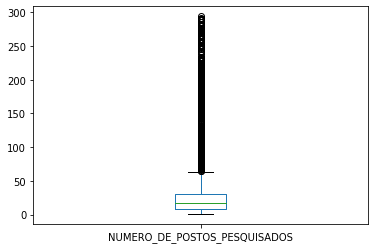

In [504]:
data_per_cmeter = data_per_cmeter_no_nan
n_postos_pesq_cmeter = data_per_cmeter['NUMERO_DE_POSTOS_PESQUISADOS']
n_postos_pesq_cmeter.plot.box()

Parece se tratar de uma distribuição bastante enviesada, investiguemo-la, e vejamos se é possível simetrizá-la via logaritmo ou raiz quadrada

<AxesSubplot:>

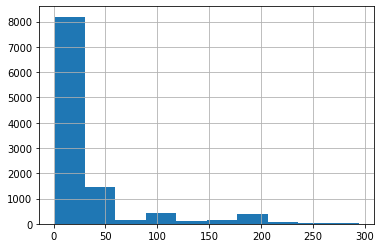

In [505]:
n_postos_pesq_cmeter.hist()

<AxesSubplot:>

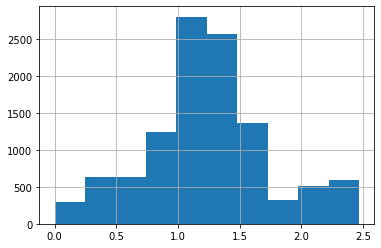

In [506]:
pesq_cmeter_no_zero = n_postos_pesq_cmeter.replace({ 0: 1e-15 })
np.log10(pesq_cmeter_no_zero).hist()

Com alguma flexibilidade, podemos considerar a distribuição obtida via logaritmo como simétrica. Utilizemos, então, o método MAD para remoção de outliers

<AxesSubplot:>

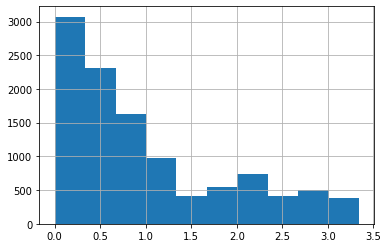

In [507]:
pesq_cmeter_mad = np.log10(pesq_cmeter_no_zero)
pesq_cmeter_mad = np.abs(pesq_cmeter_mad - pesq_cmeter_mad.median()) / pesq_cmeter_mad.mad()
pesq_cmeter_mad.hist()

Nenhum valor superou o limiar de 3.5, a partir do qual recomenda-se remoção. Sigamos com o preço médio de revenda

<AxesSubplot:>

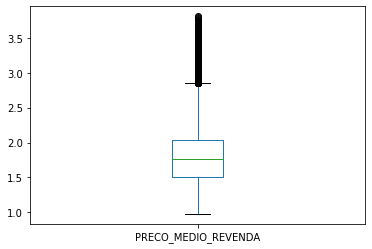

In [508]:
mean_resell_cmeter = data_per_cmeter['PRECO_MEDIO_REVENDA']
mean_resell_cmeter.plot.box()

<AxesSubplot:>

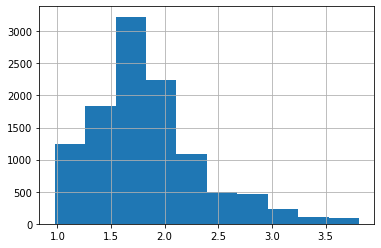

In [509]:
mean_resell_cmeter.hist()

Os valores de revenda mostrados no plot acima parecem inapropriados, pois sugerem valores de revenda entre um e quatro reais por metro cúbico, o que é improvável se considerarmos que um metro cúbico equivale a mil litros. Vamos plotar um gráfico do valor médio de revenda pelo tempo

<AxesSubplot:xlabel='DATA_INICIAL'>

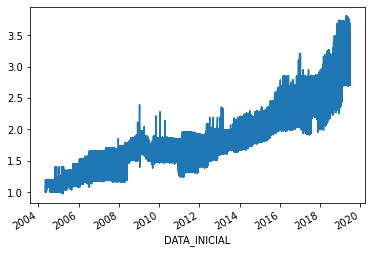

In [510]:
data_per_cmeter.index = data_per_cmeter['DATA_INICIAL']
mean_resell_cmeter = data_per_cmeter['PRECO_MEDIO_REVENDA']
mean_resell_cmeter.plot()

Vamos continuar nossa análise sob a hipótese dos valores mostrados se tratarem, na realidade, de milhares de reais por metro cúbico. Quanto à distribuição enviesada, a justificativa parece se mostrar nos aumentos recentes aos preços de combustíveis. Sigamos para o desvio padrão de revenda

<AxesSubplot:>

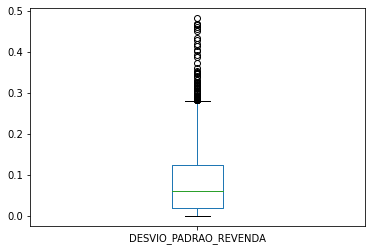

In [511]:
resell_std_cmeter = data_per_cmeter['DESVIO_PADRAO_REVENDA']
resell_std_cmeter.plot.box()

<AxesSubplot:xlabel='DATA_INICIAL'>

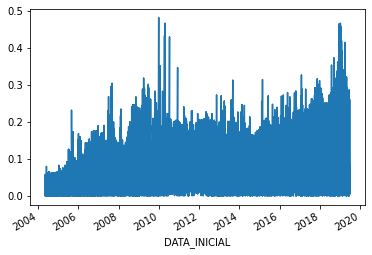

In [512]:
resell_std_cmeter.plot()

<AxesSubplot:>

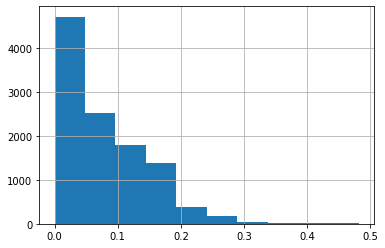

In [513]:
resell_std_cmeter.hist()

Tentemos utilizar o logaritmo para obter uma distribuição simétrica

<AxesSubplot:>

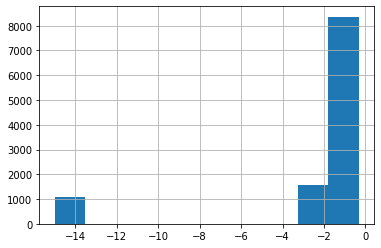

In [514]:
resell_std_cmeter_no_zero = resell_std_cmeter.replace({ 0: 1e-15 })
resell_std_cmeter_log = np.log10(resell_std_cmeter_no_zero)
resell_std_cmeter_log.hist()

Não tivemos sucesso. Tentemos a partir da raiz quadrada

<AxesSubplot:>

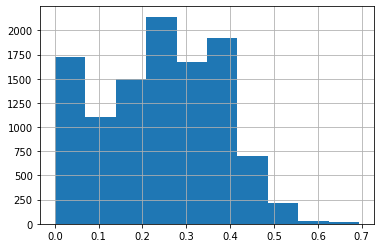

In [515]:
resell_std_cmeter_sqrt = np.sqrt(resell_std_cmeter)
resell_std_cmeter_sqrt.hist()

Obtivemos uma distribuição mais próxima da simetria. Utilizemos o MAD novamente

<AxesSubplot:>

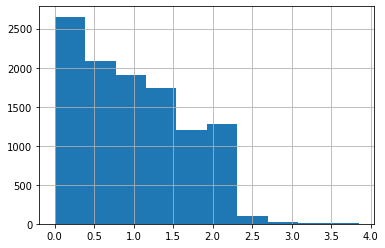

In [516]:
resell_std_cmeter_mad = np.abs(resell_std_cmeter_sqrt - resell_std_cmeter_sqrt.median()) / resell_std_cmeter_sqrt.mad()
resell_std_cmeter_mad.hist()

Alguns poucos valores superaram o limiar de 3.5. Vamos removê-los

In [517]:
print(f'Quantidade de linhas anterior à remoção: {len(data_per_cmeter)}')
no_resell_std_out_cmeter = data_per_cmeter[resell_std_cmeter_mad < 3.5]
print(f'Quantidade de linhas após remoção: {len(no_resell_std_out_cmeter)}')

Quantidade de linhas anterior à remoção: 11006
Quantidade de linhas após remoção: 10997


Prossigamos para o preço mínimo de revenda

<AxesSubplot:>

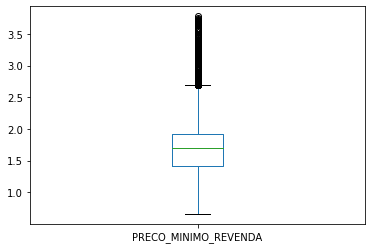

In [518]:
min_resell_cmeter = no_resell_std_out_cmeter['PRECO_MINIMO_REVENDA']
min_resell_cmeter.plot.box()

<AxesSubplot:xlabel='DATA_INICIAL'>

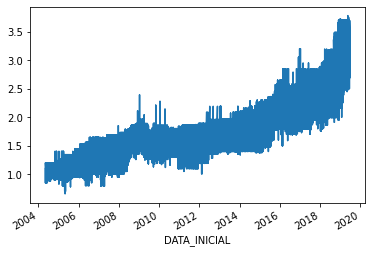

In [519]:
min_resell_cmeter.plot()

Mais uma vez, os outliers parecem se justificar nos aumentos recentes nos preços dos combustíveis. Prossigamos para o preço máximo de revenda, onde esperamos o mesmo comportamento da evolução dos valores.

<AxesSubplot:xlabel='DATA_INICIAL'>

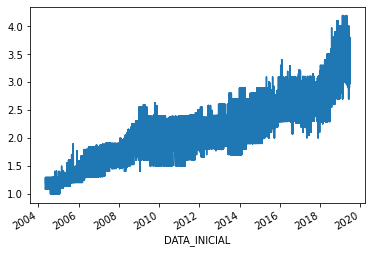

In [520]:
max_resell_cmeter = no_resell_std_out_cmeter['PRECO_MAXIMO_REVENDA']
max_resell_cmeter.plot()

De fato, os valores possuem aclive nos meses recentes. Prossigamos para a margem média de revenda.

<AxesSubplot:>

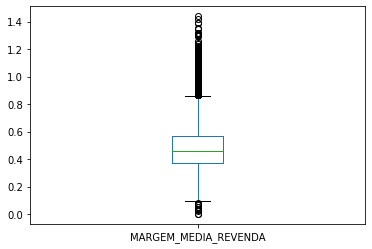

In [521]:
margin_cmeter = no_resell_std_out_cmeter['MARGEM_MEDIA_REVENDA']
margin_cmeter.plot.box()

<AxesSubplot:xlabel='DATA_INICIAL'>

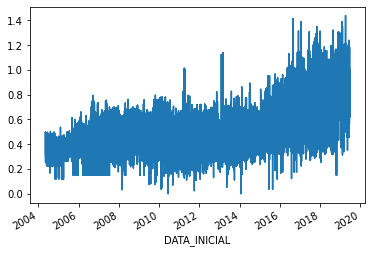

In [522]:
margin_cmeter.plot()

Verifiquemos se os valores observados condizem com as diferenças entre preço médio de revenda e preço médio de distribuição.

<AxesSubplot:xlabel='DATA_INICIAL'>

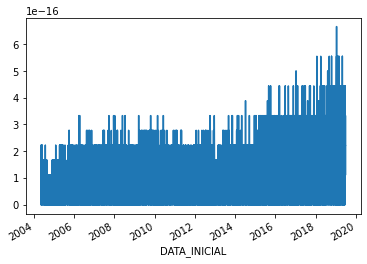

In [523]:
expected_actual_diff = np.abs(margin_cmeter - (no_resell_std_out_cmeter['PRECO_MEDIO_REVENDA'] - no_resell_std_out_cmeter['PRECO_MEDIO_DISTRIBUICAO']))
expected_actual_diff.plot()

Observando-se as diferenças mínimas entre valores registrados e os deduzidos, podemos dizer que os valores de margem média de revenda estão de acordo com o esperado. Prossigamos para o coeficiente de variação de revenda.

<AxesSubplot:>

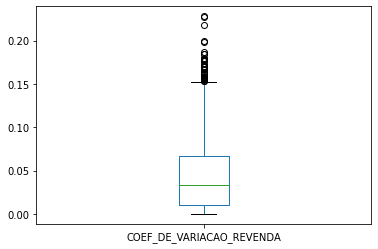

In [524]:
coef_resell_cmeter = no_resell_std_out_cmeter['COEF_DE_VARIACAO_REVENDA']
coef_resell_cmeter.plot.box()

<AxesSubplot:xlabel='DATA_INICIAL'>

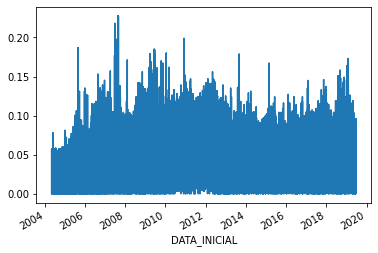

In [525]:
coef_resell_cmeter.plot()

Os outliers não parecem ter alguma relação em particular com épocas. Verifiquemos o formato da distribuição, que, pelo boxplot, parece ser enviesado.

<AxesSubplot:>

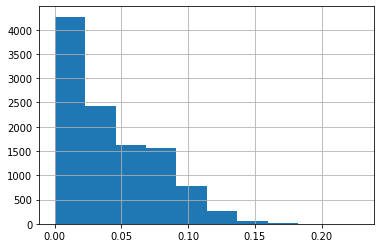

In [526]:
coef_resell_cmeter.hist()

Esse histograma se assemelha em formato ao de desvio padrão de preço de revenda. Tentemos, como para aquele, usar a raiz quadrada para obter uma distribuição simétrica.

<AxesSubplot:>

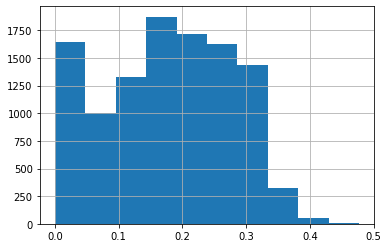

In [527]:
coef_resell_cmeter_sqrt = np.sqrt(coef_resell_cmeter)
coef_resell_cmeter_sqrt.hist()

Utilizemos MAD para a remoção de outliers

<AxesSubplot:>

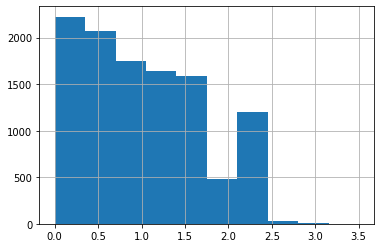

In [528]:
coef_resell_cmeter_mad = np.abs(coef_resell_cmeter_sqrt - coef_resell_cmeter_sqrt.median()) / coef_resell_cmeter_sqrt.mad()
coef_resell_cmeter_mad.hist()

Nenhum valor mostrou-se acima do limiar e, portanto, vamos mantê-los. Sigamos para o preço médio de distribuição.

<AxesSubplot:>

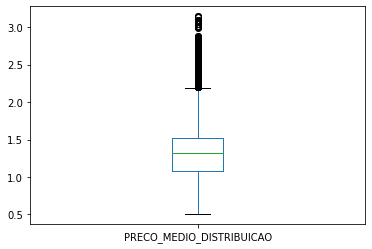

In [529]:
mean_dist_cmeter = no_resell_std_out_cmeter['PRECO_MEDIO_DISTRIBUICAO']
mean_dist_cmeter.plot.box()

<AxesSubplot:xlabel='DATA_INICIAL'>

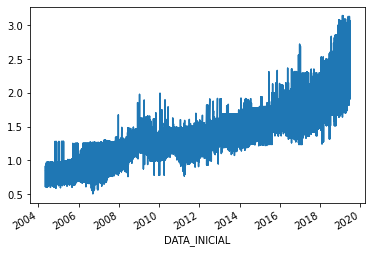

In [530]:
mean_dist_cmeter.plot()

Os outliers parecem ligados às épocas recentes. Sigamos para o desvio padrão de distribuição.

<AxesSubplot:>

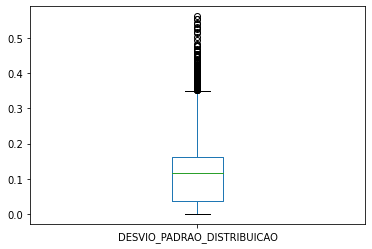

In [531]:
dist_std_cmeter = no_resell_std_out_cmeter['DESVIO_PADRAO_DISTRIBUICAO']
dist_std_cmeter.plot.box()

<AxesSubplot:xlabel='DATA_INICIAL'>

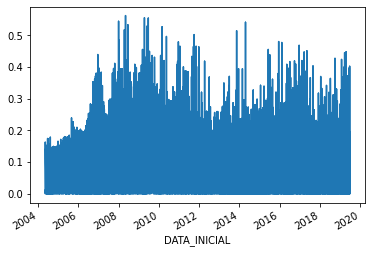

In [532]:
dist_std_cmeter.plot()

<AxesSubplot:>

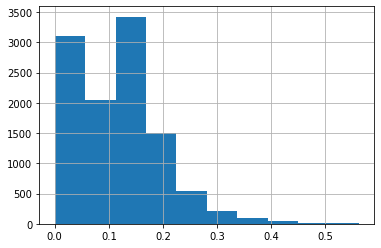

In [533]:
dist_std_cmeter.hist()

Tentemos obter uma distribuição simétrica pelo uso de logaritmo ou raiz quadrada

<AxesSubplot:>

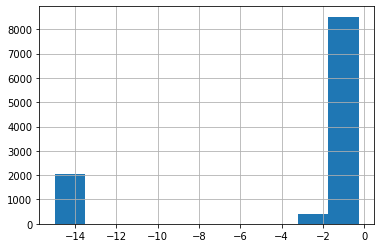

In [534]:
dist_std_cmeter_no_zero = dist_std_cmeter.replace({ 0: 1e-15 })
np.log10(dist_std_cmeter_no_zero).hist()

<AxesSubplot:>

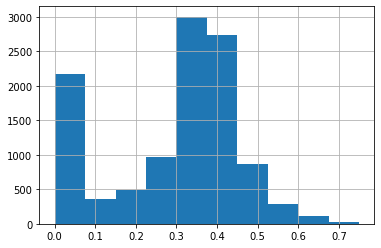

In [535]:
np.sqrt(dist_std_cmeter).hist()

Não conseguimos obter distribuições simétricas, de forma que manteremos os outliers. Sigamos com preço mínimo de distribuição.

<AxesSubplot:xlabel='DATA_INICIAL'>

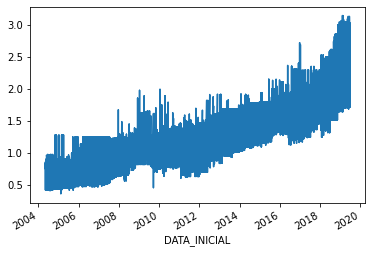

In [536]:
min_dist_cmeter = no_resell_std_out_cmeter['PRECO_MINIMO_DISTRIBUICAO']
min_dist_cmeter.plot()

Novamente, os outliers localizariam-se no aclive de épocas recentes. Esperamos o mesmo comportamento para a distribuição dos valores de preços máximos de distribuição.

<AxesSubplot:xlabel='DATA_INICIAL'>

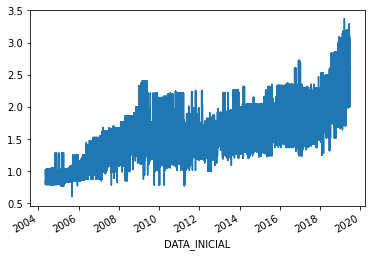

In [537]:
max_dist_cmeter = no_resell_std_out_cmeter['PRECO_MAXIMO_DISTRIBUICAO']
max_dist_cmeter.plot()

A observação está de acordo com o esperado. Terminemos a remoção de outliers, agora, com o coeficiente de variação de distribuição.

<AxesSubplot:xlabel='DATA_INICIAL'>

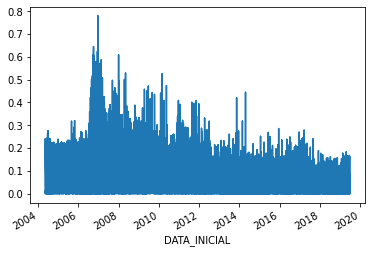

In [538]:
coef_dist_cmeter = no_resell_std_out_cmeter['COEF_DE_VARIACAO_DISTRIBUICAO']
coef_dist_cmeter.plot()

Os valores não parecem ter relação específica com épocas. Verifiquemos sua distribuição, e se podemos remover outliers.

<AxesSubplot:>

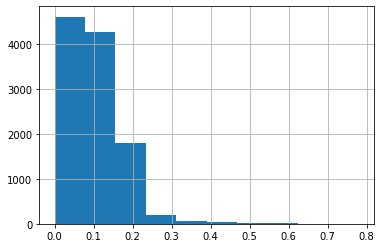

In [539]:
coef_dist_cmeter.hist()

<AxesSubplot:>

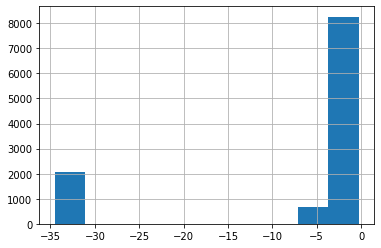

In [540]:
coef_dist_cmeter_no_zero = coef_dist_cmeter.replace({ 0: 1e-15 })
coef_dist_cmeter_log = np.log(coef_dist_cmeter_no_zero)
coef_dist_cmeter_log.hist()

Não conseguimos uma distribuição simétrica. Tentemos utilizar a raiz quadrada.

<AxesSubplot:>

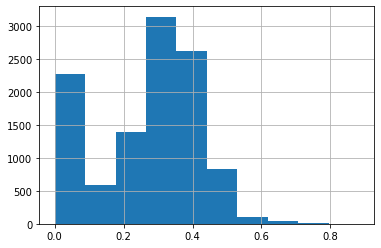

In [541]:
coef_dist_cmeter_sqrt = np.sqrt(coef_dist_cmeter)
coef_dist_cmeter_sqrt.hist()

Não foi possível obter uma distribuição simétrica, de forma que manteremos os outliers.

<AxesSubplot:xlabel='ESTADO'>

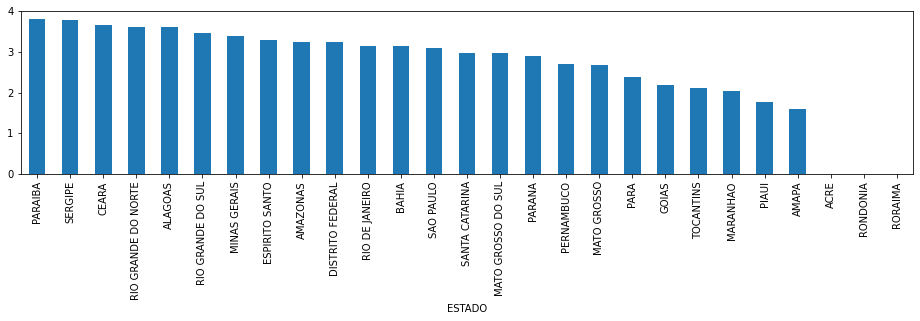

In [542]:
per_cmeter_clean = no_resell_std_out_cmeter
grouped_by_state = per_cmeter_clean.groupby('ESTADO')
grouped_by_state['PRECO_MEDIO_REVENDA'].max().sort_values(ascending=False).plot.bar(figsize=(16, 3), rot=90)

A diferença entre os preços médios para R$/m³ por estado não é considerável como em R$/13kg. Vejamos a diferença de maior valor

In [543]:
mean_resell_by_state = grouped_by_state['PRECO_MEDIO_REVENDA']
mean_resell_by_state.max().max() - mean_resell_by_state.max().min()

2.213

Vemos novamente que os estados Paraíba e Amapá possuem a
 maior diferença, vejamos o valor

In [544]:
mean_resell_by_state = grouped_by_state['PRECO_MEDIO_REVENDA']
mean_resell_by_state.max().max() - mean_resell_by_state.max().min()


2.213

<AxesSubplot:xlabel='DATA_INICIAL'>

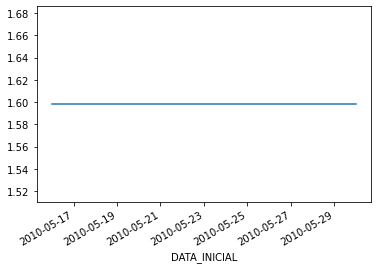

In [545]:
per_cmeter_clean[per_cmeter_clean['ESTADO'] == 'AMAPA']['PRECO_MEDIO_REVENDA'].plot()

Vemos que não há dados o suficiente para análise com o estado do Amapá,
por isso vamos considerar o estado de Pernambuco

<AxesSubplot:xlabel='DATA_INICIAL'>

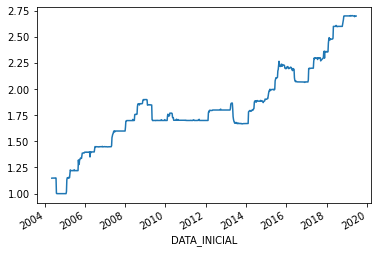

In [546]:
per_cmeter_clean[per_cmeter_clean['ESTADO'] == 'PERNAMBUCO']['PRECO_MEDIO_REVENDA'].plot()

<AxesSubplot:xlabel='DATA_INICIAL'>

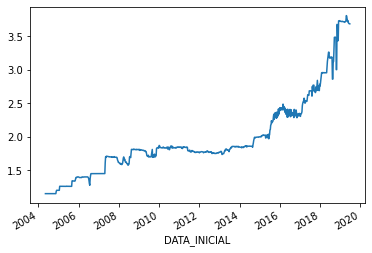

In [547]:
per_cmeter_clean[per_cmeter_clean['ESTADO'] == 'PARAIBA']['PRECO_MEDIO_REVENDA'].plot()

<AxesSubplot:xlabel='DATA_INICIAL'>

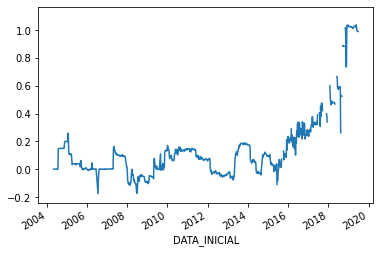

In [548]:
mean_resell_PE = per_cmeter_clean[per_cmeter_clean['ESTADO'] == 'PERNAMBUCO']
mean_resell_PB = per_cmeter_clean[per_cmeter_clean['ESTADO'] == 'PARAIBA']

(mean_resell_PB['PRECO_MEDIO_REVENDA'] - mean_resell_PE['PRECO_MEDIO_REVENDA']).plot()

As curvas de evolução do preço médio de revenda tem formatos semelhantes,
sendo que Pernambuco historicamente tem preços médios mais baixos que a Paraíba.
Pelo gráfico das diferenças com relação ao tempo, vê-se que, em certo ponto entre 2019 e 2020,
essa diferença esteve acima de R$10,00. Vamos procurar nos informar da data em que houve
a maior diferença entre um máximo e um mínimo preço médio de revenda.


In [549]:
grouped_by_date = per_cmeter_clean.reset_index(drop=True).groupby('DATA_INICIAL')

max_diffs = (grouped_by_date['PRECO_MEDIO_REVENDA'].max() - grouped_by_date['PRECO_MEDIO_REVENDA'].min())
max_diffs[max_diffs == max_diffs.max()]


DATA_INICIAL
2018-12-09    1.475
Name: PRECO_MEDIO_REVENDA, dtype: float64

O resultado aponta para a pesquisa da data de 9 de dezembro de 2018.
 É um detalhe importante que um estado pode aparecer mais de uma vez para uma pesquisa,
 portanto o que mostra o gráfico pode não refletir o resultado obtido acima. Vamos obter
os valores médios de preços médios de revenda para essa data, e plotá-los em seguida.

<AxesSubplot:xlabel='ESTADO'>

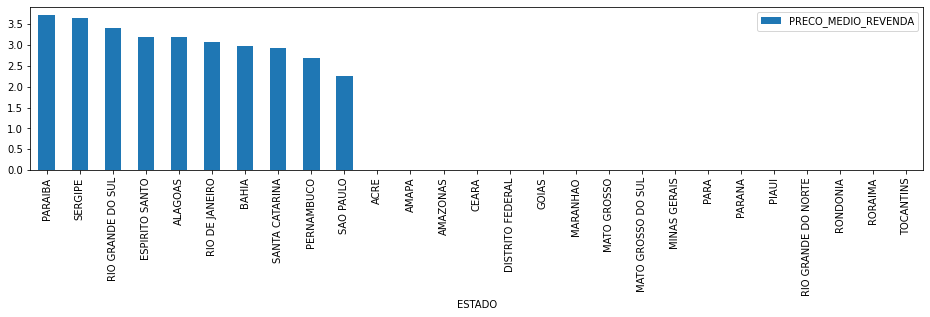

In [550]:
per_cmeter_clean.loc['2018-12-09'].groupby('ESTADO').mean().sort_values('PRECO_MEDIO_REVENDA', ascending=False).plot.bar(y='PRECO_MEDIO_REVENDA', figsize=(16, 3))


Façamos agora a normailzação min-max para os dados.

In [551]:
data_per_cmeter_norm = no_resell_std_out_cmeter.copy()
cols_to_norm = data_per_cmeter_norm[
    [
     'NUMERO_DE_POSTOS_PESQUISADOS',
     'PRECO_MEDIO_REVENDA',
     'PRECO_MEDIO_DISTRIBUICAO',
     'DESVIO_PADRAO_REVENDA',
     'PRECO_MINIMO_REVENDA',
     'PRECO_MAXIMO_REVENDA',
     'PRECO_MINIMO_DISTRIBUICAO',
     'PRECO_MAXIMO_DISTRIBUICAO',
     'COEF_DE_VARIACAO_REVENDA',
     'MARGEM_MEDIA_REVENDA'
    ]
]

data_per_cmeter_norm[
    [
     'NUMERO_DE_POSTOS_PESQUISADOS',
     'PRECO_MEDIO_REVENDA',
     'PRECO_MEDIO_DISTRIBUICAO',
     'DESVIO_PADRAO_REVENDA',
     'PRECO_MINIMO_REVENDA',
     'PRECO_MAXIMO_REVENDA',
     'PRECO_MINIMO_DISTRIBUICAO',
     'PRECO_MAXIMO_DISTRIBUICAO',
     'COEF_DE_VARIACAO_REVENDA',
     'MARGEM_MEDIA_REVENDA'
    ]
] = (cols_to_norm - cols_to_norm.min()) / (cols_to_norm.max() - cols_to_norm.min())

data_per_cmeter_norm.describe()

,Unnamed:_0,NUMERO_DE_POSTOS_PESQUISADOS,PRECO_MEDIO_REVENDA,DESVIO_PADRAO_REVENDA,PRECO_MINIMO_REVENDA,PRECO_MAXIMO_REVENDA,MARGEM_MEDIA_REVENDA,COEF_DE_VARIACAO_REVENDA,PRECO_MEDIO_DISTRIBUICAO,DESVIO_PADRAO_DISTRIBUICAO,PRECO_MINIMO_DISTRIBUICAO,PRECO_MAXIMO_DISTRIBUICAO,COEF_DE_VARIACAO_DISTRIBUICAO,MES,ANO
count,10997.000000,10997.000000,10997.000000,10997.000000,10997.000000,10997.000000,10997.000000,10997.000000,10997.000000,10997.000000,10997.000000,10997.000000,10997.000000,10997.000000,10997.000000
mean,55468.160589,0.110400,0.304466,0.182126,0.349308,0.329562,0.342875,0.181207,0.317831,0.113039,0.300660,0.327344,0.094530,6.468128,2011.018096
std,21790.839370,0.163890,0.177674,0.159805,0.157688,0.181870,0.124800,0.155879,0.151670,0.085679,0.158458,0.147221,0.076662,3.434362,4.309669
min,36196.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000,2004.000000
25%,39045.000000,0.027304,0.184767,0.045346,0.243832,0.204638,0.260264,0.043860,0.216370,0.036000,0.186489,0.231610,0.026000,4.000000,2007.000000
50%,42121.000000,0.054608,0.280677,0.147971,0.333227,0.310561,0.318024,0.144737,0.309208,0.118000,0.296110,0.318116,0.093000,6.000000,2011.000000
75%,72218.000000,0.102389,0.374824,0.295943,0.407241,0.429332,0.395964,0.293860,0.385373,0.162000,0.374739,0.397050,0.141000,9.000000,2015.000000
max,106822.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,0.562000,1.000000,1.000000,0.780000,12.000000,2019.000000
